In [2]:
import os
from IPython.display import display, Image
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy.stats import linregress
import math
from functools import reduce
import matplotlib

In [3]:
import argparse
from Bio import SeqIO, Entrez, pairwise2
Entrez.email = 'hongyingsun1101@gmail.com'
from Bio.SeqRecord import SeqRecord
import re, time
import os, sys, glob
import random
import uuid
# from skbio.tree import TreeNode
# from skbio import read
# from skbio.stats.distance import DistanceMatrix
# from skbio.stats.distance import DissimilarityMatrix

from scipy import stats
from ast import literal_eval
import sqlite3

# community-based correlation between score and pplacer stats, log transform adcl
Are the correlation consistent between difference reference sets?
a set of correlations on categorical data K-squared test: community accuracy vs cutoff for pplacer stats 
community based sensitivity test
optimal cutoff analysis: 

are the bad values consistent across different data sets?
community based level analysis?

In [4]:
class displayFancy(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [5]:
""" set up fonts here before importing matplotlib.pylab """
parms = {'font.family': 'serif', 'font.serif': 'Palatino', 'svg.fonttype': 'none'}
plt.rcParams.update(parms)
sns.set(context='talk', style='darkgrid', palette='deep', font='sans-serif')

In [6]:
mock_seqtab=pd.read_csv("CC11.map.SeqTable.csv",index_col=0)
df_sv_list_names=['mock','rdp_10398','rdp_5224','rdp_1017','rdp_92','rdp_12']
taxaFiles=["AbundanceOfTaxIdInSamples_primaryTaxid.csv"]+[d+ "_"+"oneRankEachSV_keepBest.csv" for d in df_sv_list_names[1:]]
taxaDB="taxonomy.db"
nDlists=len(df_sv_list_names)

In [7]:
nDlists

6

In [8]:
#this function creats a list of files containing mock and the 5 rdp data in the same list with the same format.
def prepareFiles():
    df_sv_list=[]
    for i, f in enumerate(taxaFiles):
        if i==0: #mock
            mock=mock_seqtab.copy()
            sample_ids=mock['community'].unique()
            sample_ids=['CC11CM'+str(i) for i in range(sample_ids.shape[0])]
            #not all tax_ids in the mock are primary
            translate={415850:1463164,195041:45634,592977:1680, 796939:796937, 41791:126333}
            mock.ncbi_tax_id.replace(translate, inplace=True)
            mock.rename(columns={'sourceSeq':'colind','organism':'tax_name','ncbi_tax_id':'tax_id'}, inplace=True)
            sv_ids = mock.colind.unique()
            temp=pd.DataFrame(index=sv_ids,columns=['tax_id']+sample_ids)
            for s in sample_ids:
                mock_s = mock[mock.community==s]
                mock_s.set_index('colind', inplace=True)
                temp.loc[mock_s.index, 'tax_id']=mock_s['tax_id']
                temp.loc[mock_s.index, s]=mock_s['multiplicity']
            temp=temp.fillna(0)
            
        else: #analyzed using dada2/pplacer/RDP
            temp=pd.DataFrame(index=sv_ids,columns=['tax_id']+sample_ids)
            temp1=pd.read_csv(f)
            #drop rank, taxa_name and colind (SV index)
            temp1 = temp1.loc[:,['colind','tax_id']+sample_ids]
            temp1.set_index('colind',inplace=True)
            temp.loc[temp1.index,'tax_id']=temp1['tax_id']
            temp.loc[temp1.index,sample_ids]=temp1[sample_ids]
            temp=temp.fillna(0)

        ##very strange tax_id for the mock is not duplicated but when I set the index as tax_id for the mock the index and the mock becomes duplicated!
        df_sv_list.append(temp)
        #print(temp.head())
    return df_sv_list
# generates the file list which has the mock data and the 5 data generated from pplacer. 
df_sv_list = prepareFiles()

dircs=[i+"/" for i in df_sv_list_names[1:]]

In [11]:
df_sv_list[1].head()

,tax_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
AB036759.1.1480,113286,9.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB253730.1.1456,816,4656.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB253731.1.1463,816,1579.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB298910.1.1471,1730,1066.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB510708.1.1476,816,684.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_sv_list[0].head()

,tax_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
AB036759.1.1480,113287,9,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB253730.1.1456,376804,4656,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB253731.1.1463,376805,1579,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB298910.1.1471,1736,1066,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB510708.1.1476,46506,684,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def getUniqueSet(alltaxids):
    out=set(alltaxids[0])
    for l in alltaxids[1:]:
        out=out.union(l)
    return out
allsv=[df_sv_list[i].index.astype(str) for i in range(nDlists)]
allt=[df_sv_list[i].tax_id.astype(str) for i in range(nDlists)]
alls=[df_sv_list[i].columns.astype(str) for i in range(nDlists)]
alltaxa=getUniqueSet(allt)
allsvs=getUniqueSet(allsv)
allsamples=getUniqueSet(alls)

In [8]:
test_df =df_sv_list[0]

In [9]:
all_index = ['mock','rdp_10398','rdp_5224','rdp_1017','rdp_92','rdp_12']
# merged_df_all = pd.concat([pd.DataFrame('df_sv_list[0]'),pd.DataFrame('df_sv_list[1]')])
# merged_df_all.head()
pd.concat([df_sv_list[0],df_sv_list[1]], axis=1).head()

,tax_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
AB036759.1.1480,113287,9,11,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB253730.1.1456,376804,4656,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB253731.1.1463,376805,1579,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB298910.1.1471,1736,1066,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB510708.1.1476,46506,684,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except ConnectionError as e:
        print(e)

    return None

In [11]:
# generate tables for analysis.
mock=df_sv_list[0]
df_merge=pd.DataFrame(index=list(allsvs))
df_merge.index.name="sv_id"
mock_tab1=df_merge.merge(mock,how='left', left_index=True, right_index=True)
mock_tab1=mock_tab1.fillna(0)
ref_tabs={}
def generateFiles():
    for i, df in enumerate(df_sv_list[1:],1):
        ana_tab2=df_merge.merge(df, how="left", left_index=True, right_index=True)
        ana_tab2=ana_tab2.fillna(0)
        ref_tabs[df_sv_list_names[i]]=ana_tab2
    return ref_tabs
ref_tabs = generateFiles()

In [12]:
ref_tabs['rdp_10398'].head()

,tax_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
sv_id,,,,,,,,,,,,,,,,,,,,,
NR_044400.1,29465,0.0,0.0,0.0,184.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0
CP001071.320473.321977,239934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JHYB01000010.85.1425,2147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACIF01000047.49.1542,848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGXH01000076.81191.82710,816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_sv_list[0].head()

,tax_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
AB036759.1.1480,113287,9,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB253730.1.1456,376804,4656,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB253731.1.1463,376805,1579,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB298910.1.1471,1736,1066,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB510708.1.1476,46506,684,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
rdp_10398_predicted = ref_tabs['rdp_10398']
rdp_5224_predicted = ref_tabs['rdp_5224']
rdp_10398_predicted.head()

,tax_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
sv_id,,,,,,,,,,,,,,,,,,,,,
NR_044400.1,29465,0.0,0.0,0.0,184.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0
CP001071.320473.321977,239934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JHYB01000010.85.1425,2147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACIF01000047.49.1542,848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGXH01000076.81191.82710,816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
conn = create_connection(taxaDB)

In [16]:
# read csv files
score_table = pd.read_csv('score_table2.csv', index_col=0)
adcl_table = pd.read_csv('adcl_bySV_allsamples.csv', index_col=0)
score_table.describe()

,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,CC11CM9,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
count,55.000000,73.000000,40.000000,59.000000,52.000000,61.000000,54.000000,67.000000,65.000000,57.000000,...,48.000000,59.000000,53.000000,61.000000,53.000000,61.000000,50.000000,57.000000,62.000000,56.000000
mean,4.618182,4.410959,3.250000,3.152542,2.230769,4.754098,3.111111,4.089552,4.184615,3.473684,...,3.583333,2.135593,3.207547,3.475410,4.226415,4.163934,3.160000,3.824561,3.806452,3.285714
std,8.910025,8.055081,5.776833,5.148865,1.352056,8.564765,5.265289,7.314849,7.405429,6.375470,...,7.310247,1.332066,5.238021,6.130814,8.130289,7.644563,5.658153,6.636272,6.216949,5.207387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,38.000000,38.000000,38.000000,38.000000,6.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,6.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000


## Sensitivity Analylsis

In [17]:
def percentageCorrect(mock_seqtab, taxaFiles,df_sv_list_names, withMultiplicity=True):
    mock=mock_seqtab.copy()
    #not all tax_ids in the mock are primary
    translate={415850:1463164,195041:45634,592977:1680, 796939:796937, 41791:126333}
    mock.ncbi_tax_id.replace(translate, inplace=True)
    mock.rename(columns={'sourceSeq':'colind'}, inplace=True)
    mock = mock[['community', 'colind','organism', 'ncbi_tax_id', 'multiplicity']]
    mock_gpbySample = mock.groupby('community', as_index=True)
    sample_ids=[list(mock_gpbySample)[i][0] for i in range(len(list(mock_gpbySample)))]
    df_pcorrect=pd.DataFrame(index=sample_ids)
    for i, f in enumerate(taxaFiles[1:],1):
        temp = pd.read_csv(f, index_col=0) #multisample assignment 
        for s in  sample_ids:
            merged=mock_gpbySample.get_group(s).merge(temp[['tax_id', 'tax_name', 'colind']+[s]], how='left', on='colind') #merge on SVs=sourceSeq
            merged.loc[:,"iscorrect"]=(merged['ncbi_tax_id'].astype(str)==merged['tax_id'].astype(str)).astype(int)
            if withMultiplicity:
                df_pcorrect.loc[s,df_sv_list_names[i]]=((merged['iscorrect']*merged['multiplicity'])/merged['multiplicity'].sum()).sum()*100.0 #percentage correct
            else:
                df_pcorrect.loc[s,df_sv_list_names[i]]=(merged['iscorrect']).mean()*100.0 #percentage correct
    return sample_ids, df_pcorrect

sample_ids, df_pcorrect=percentageCorrect(mock_seqtab, taxaFiles,df_sv_list_names)
sample_ids_woMulti, df_pcorrect_woMulti=percentageCorrect(mock_seqtab, taxaFiles,df_sv_list_names, withMultiplicity=False)


In [18]:
df_pcorrect.mean()

rdp_10398    3.763598
rdp_5224     3.446103
rdp_1017     2.619771
rdp_92       1.100746
rdp_12       0.000000
dtype: float64

In [19]:
rdp_10398_predicted.head()

,tax_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
sv_id,,,,,,,,,,,,,,,,,,,,,
NR_044400.1,29465,0.0,0.0,0.0,184.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0
CP001071.320473.321977,239934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JHYB01000010.85.1425,2147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACIF01000047.49.1542,848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGXH01000076.81191.82710,816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
mock=mock_seqtab.copy()
translate={415850:1463164,195041:45634,592977:1680, 796939:796937, 41791:126333}
mock.ncbi_tax_id.replace(translate, inplace=True)
mock.rename(columns={'sourceSeq':'colind'}, inplace=True)
mock = mock[['community', 'colind','organism', 'ncbi_tax_id', 'multiplicity']]
mock_gpbySample = mock.groupby('community', as_index=True)
# df_pcorrect=pd.DataFrame(index=sample_ids)
temp0 = pd.read_csv("rdp_10398_oneRankEachSV_keepBest.csv", index_col=0)
temp0.head(3)

,rank,tax_id,tax_name,colind,CC11CM15,CC11CM49,CC11CM87,CC11CM64,CC11CM85,CC11CM97,...,CC11CM21,CC11CM92,CC11CM29,CC11CM56,CC11CM52,CC11CM96,CC11CM47,CC11CM31,CC11CM40,CC11CM7
0,genus,816,Bacteroides,AB050110.1.1425,718.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,genus,816,Bacteroides,AB260025.1.1492,812.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,genus,1678,Bifidobacterium,AB437350.1.1505,32.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
sample_ids=[list(mock_gpbySample)[i][0] for i in range(len(list(mock_gpbySample)))]

In [22]:
mock_seqtab.head()

,community,sourceSeq,seqID,organism,ncbi_tax_id,multiplicity
0,CC11CM0,AB036759.1.1480,CC11CM0SCR1e06de32f41c414aaa57f33949f4905c,Pseudoramibacter alactolyticus,113287,9
1,CC11CM0,AB253730.1.1456,CC11CM0SCR3e39a5fc61b6420cac1c2dd465292aec,Bacteroides barnesiae,376804,4656
2,CC11CM0,AB253731.1.1463,CC11CM0SCR3823cad73fba408b8b4a7cda1eb5e493,Bacteroides salanitronis,376805,1579
3,CC11CM0,AB298910.1.1471,CC11CM0SCR6f14135fa1ba41f49b480f6973684fb2,Eubacterium limosum,1736,1066
4,CC11CM0,AB510708.1.1476,CC11CM0SCRc168f76390fb4e7c9f4809f8d0100c39,Bacteroides stercoris,46506,684


In [23]:
displayFancy('df_pcorrect.head()', 'df_pcorrect_woMulti.head()')

,rdp_10398,rdp_5224,rdp_1017,rdp_92,rdp_12
CC11CM0,5.765636,5.765636,3.159084,2.504251,0.0
CC11CM1,0.363896,0.378621,0.000000,0.000000,0.0
CC11CM10,7.533649,7.499137,5.743113,3.020768,0.0
CC11CM11,0.623034,0.036293,0.036293,0.000000,0.0
CC11CM12,5.770894,2.601227,2.601227,0.000000,0.0
,rdp_10398,rdp_5224,rdp_1017,rdp_92,rdp_12
CC11CM0,5.454545,5.454545,3.636364,1.754386,0.0
CC11CM1,2.702703,4.054054,0.000000,0.000000,0.0
CC11CM10,10.606061,9.090909,9.090909,3.030303,0.0
CC11CM11,2.985075,1.492537,1.492537,0.000000,0.0


In [24]:
displayFancy('df_pcorrect.describe()','df_pcorrect_woMulti.describe()')

,rdp_10398,rdp_5224,rdp_1017,rdp_92,rdp_12
count,100.000000,100.000000,100.000000,100.000000,100.0
mean,3.763598,3.446103,2.619771,1.100746,0.0
std,3.971108,3.957581,3.484531,2.428087,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.740316,0.367785,0.029768,0.000000,0.0
50%,3.058512,2.628039,1.331556,0.000000,0.0
75%,5.000578,4.556366,3.813692,1.016204,0.0
max,17.456369,17.222736,15.391099,12.863422,0.0
,rdp_10398,rdp_5224,rdp_1017,rdp_92,rdp_12
count,100.000000,100.000000,100.000000,100.000000,100.0


In [25]:
df_sen=pd.DataFrame(df_pcorrect.mean().copy())
df_sen_woMulti=pd.DataFrame(df_pcorrect_woMulti.mean().copy())

In [26]:

df_sen.columns = [ "Sensitivity"]
df_sen.index.name = 'Reference'
df_sen_woMulti.columns = [ "Sensitivity_wo_multi"]
df_sen_woMulti.index.name = 'Reference'
sen_table = pd.concat([df_sen, df_sen_woMulti], axis=1)
sen_table

,Sensitivity,Sensitivity_wo_multi
Reference,,
rdp_10398,3.763598,4.319489
rdp_5224,3.446103,3.621532
rdp_1017,2.619771,2.422105
rdp_92,1.100746,0.771246
rdp_12,0.000000,0.000000


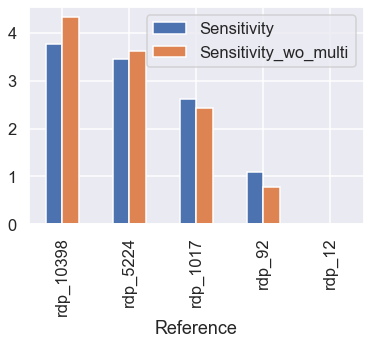

In [27]:
sen_plot = sen_table.plot.bar()

## Score Analysis

In [28]:
display(score_table.head())
display(score_table.shape)

,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,CC11CM9,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
sv_id,,,,,,,,,,,,,,,,,,,,,
AB542765.1.1491,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGXW01000013.688.2204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HQ457030.1.1394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
JHEF01000050.37729.39243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GU326240.1.1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1830, 100)

In [29]:


score=score_table.CC11CM0

In [30]:
score_table.describe()

,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,CC11CM9,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
count,55.000000,73.000000,40.000000,59.000000,52.000000,61.000000,54.000000,67.000000,65.000000,57.000000,...,48.000000,59.000000,53.000000,61.000000,53.000000,61.000000,50.000000,57.000000,62.000000,56.000000
mean,4.618182,4.410959,3.250000,3.152542,2.230769,4.754098,3.111111,4.089552,4.184615,3.473684,...,3.583333,2.135593,3.207547,3.475410,4.226415,4.163934,3.160000,3.824561,3.806452,3.285714
std,8.910025,8.055081,5.776833,5.148865,1.352056,8.564765,5.265289,7.314849,7.405429,6.375470,...,7.310247,1.332066,5.238021,6.130814,8.130289,7.644563,5.658153,6.636272,6.216949,5.207387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,38.000000,38.000000,38.000000,38.000000,6.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,6.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000


In [31]:
def get_tax_data(taxid):
    """once we have the taxid, we can fetch the record"""
    search = Entrez.efetch(id = taxid, db= "taxonomy", retmode = "xml")
    record = Entrez.read(search)
    
    return (record)

In [32]:
def get_lineage_ids_fromdata(data, uprank):
    """once you have the data from get_tax_data fetch the lineage"""
    #uprank=['kingdom','phylum','class','order','family','genus','species']
    lineage_toparse = data[0]['LineageEx']
#    print("printing data[0]:", data[0]['LineageEx'])
#    print("hahha..............")
    lineage=dict()
    ids=dict()
    for l in lineage_toparse:
#        print("printing l:", l)
        for r in uprank:
            try:
                if l['Rank']==r:
                    lineage[r]=l['ScientificName']
                    ids[r]=l['TaxId']
            except:
                pass
    return lineage, ids

In [33]:
# this function outputs all the names and ids of every level given a taxid and a connection bulit from SQL database. 
def get_lineage_ids(taxid, conn):
    """ This function gets the names and ids if all parents of the given id """

    query="SELECT nd.tax_id, nd.parent_id, nd.rank, na.tax_id, na.tax_name, na.name_class from nodes nd inner join names na on nd.tax_id=na.tax_id where na.name_class=='scientific name' AND na.tax_id==" + "'"+taxid+"'"

    df = pd.read_sql_query(query, conn)
    #print(df)

    df.columns=['tax_id', 'parent_id', 'rank', 'tax_id_drop', 'tax_name', 'name_class']
    df.drop("tax_id_drop",axis=1, inplace=True)
    rankorder=np.array(['no_rank','superkingdom','phylum','class','order','family','genus','species'])[::-1]
    #print(df['rank'])
    if not df['rank'].iloc[0].strip() in rankorder:
        rankorder=np.append(rankorder,df['rank'].iloc[0])
    rank_ind=np.where(df['rank'].iloc[0]==rankorder)[0][0]
#    if len(df.tax_name.iloc[0].split(" "))>=2:
#        lineage={rankorder[rank_ind]:" ".join(df.tax_name.iloc[0].split(" ")[1:])}
#    else:
#        lineage={rankorder[rank_ind]:df.tax_name.iloc[0]}

    lineage={rankorder[rank_ind]:df.tax_name.iloc[0]}
    ids={rankorder[rank_ind]: taxid}
    stop=False
    temp=df.copy()
    #print(lineage, ids)
    while not stop:
        parent_id=temp['parent_id'].iloc[0]
        if parent_id is None or parent_id=="" or parent_id=='0':
            stop=True
            break
        #print(parent_id)
        query="SELECT nd.tax_id, nd.parent_id, nd.rank, na.tax_id, na.tax_name, na.name_class from nodes nd inner join names na on nd.tax_id=na.tax_id where na.name_class=='scientific name' AND na.tax_id==" + "'"+parent_id+"'"
        temp = pd.read_sql_query(query, conn)
        temp.columns=['tax_id', 'parent_id', 'rank', 'tax_id_drop', 'tax_name', 'name_class']
        temp.drop("tax_id_drop",axis=1, inplace=True)
        lineage.update({temp['rank'].iloc[0]:temp['tax_name'].iloc[0]})

        ids.update({temp['rank'].iloc[0]: temp.tax_id.iloc[0]})



    return lineage, ids

In [34]:
def get_parent(taxid, taxaDB):
    parent_rank=False
    parent_taxid=False
    if taxid=='2':
        return parent_taxid, parent_rank
    #create connection:
    conn = create_connection(taxaDB)
    ranks=np.array(['superkingdom','phylum','subphylum','class','subclass','order','suborder', 'family','genus','species', 'subspecies'])
    try:
        lineage, ids = get_lineage_ids(str(taxid), conn)
    except:
        data_t=get_tax_data(str(taxid))
        lineage, ids = get_lineage_ids_fromdata(data_t, ranks) 

    if type(ids)==dict:
        allparents = ids
    elif type(temp[0])==dict:
        allparents = ids[0]
    else:
        print("Caught exception")
        sys.exit(1)

    rankorder=ranks[::-1]
    #handling when the taxid is itself among parent ids
    for r,i in allparents.items():
        if i==taxid: #and r != "superkingdom":
            taxid_rank=r
            ind_=np.where(rankorder==taxid_rank)[0][0]
            parent_rank=rankorder[ind_+1]


    for i, r in enumerate(rankorder):
        #handling when the taxid is itself among parent ids
        if parent_rank and taxid_rank==r:
            continue

        try:
            parent_taxid=allparents[r]
            parent_rank=r
            break
        except:
            pass
    return parent_taxid, parent_rank



In [35]:
def isSVInsample(svid, sample_id, table):
    """ table has indexes as the unique taxa and rows as samples
        if taxid exist in sample and has abundance>0 return True otherwise return False"""
    assert(table.index.name=="sv_id"),"the table has to have sv_id as its index and the index should be named sv_id"
    if np.any(table.index.isin([svid])):
        if table.loc[svid,sample_id]>0.0: #abundance is not zero
            return True
        else:
            return False
    else:
        return False

In [36]:
def istaxIDEqual(svid, sample_id, table1, table2):
    """this function implicitly assumes that svid exists in both tables for the sample_id and it checks if abundances is>0 in both 
       before comparing their tax_ids"""
    if table1.loc[svid, sample_id]>0 and table2.loc[svid, sample_id]>0:
        tax1 = table1.loc[svid, 'tax_id']
        tax2 = table2.loc[svid, 'tax_id']
    elif table1.loc[svid, sample_id]>0:
        tax1 = table1.loc[svid, 'tax_id']
        tax2=np.nan
    elif table2.loc[svid, sample_id]>0:
        tax1=np.nan
        tax2 = table2.loc[svid, 'tax_id']
    else:
        tax1=np.nan
        tax2=np.nan

    if tax1 == tax2:
        return True, tax1, tax2
    else:
        return False, tax1, tax2




In [37]:

def ranks_off(table1, table2, sv_id, sample_id, taxaDB):
    """A measure that calculates how many ranks is the SV in sample_id in table2 is off from 
       that in table1
       table1 and table2 are pandas dataframes with exactly the same indices and columns 
       columns as samples and indices as SVs"""
    ranks=['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    isInTable1=isSVInsample(sv_id, sample_id, table1)
    isInTable2=isSVInsample(sv_id, sample_id, table2)
    #SV has abundance in both
    if isInTable1 and isInTable2:
        isTaxaEq, tax1, tax2 = istaxIDEqual(sv_id, sample_id, table1, table2)
        if isTaxaEq: #SV in both and the corresponding tax_id is equal
            return 0
        else: #SV in both and the corresponding tax_ids differ 
            foundParent=False
            #try parents of tax1
            dummy_id = tax1
            output1=0
            while not foundParent and output1<7:
                print(dummy_id)
                parent_id, parent_rank =get_parent(dummy_id, taxaDB)
                if parent_id:
                    foundParent = parent_id==tax2   #istaxaInsample(parent_id, sample_id, table2)
                    dummy_id = parent_id
                    output1+=1
                else:
                    foundParent=True

            #try parents of tax1
            dummy_id = tax1
            output2=0
            while not foundParent and output2<7:
                print(dummy_id)
                parent_id, parent_rank =get_parent(dummy_id, taxaDB)
                if parent_id:
                    foundParent = parent_id==tax2   #istaxaInsample(parent_id, sample_id, table2)
                    dummy_id = parent_id
                    output2+=1
                else:
                    foundParent=True

            if output1>=output2:
                return output1
            else:
                return output2

    elif isInTable1: #not in table2
        isTaxaEq, tax1, tax2 = istaxIDEqual(sv_id, sample_id, table1, table2)
        parent_id, parent_rank =get_parent(tax1, taxaDB)
        if parent_rank in ranks:
            return ranks.index(parent_rank)+2 #plus 2 because the index starts from 0 and it is the parent
        elif parent_rank == "subspecies":
            return 7
        elif parent_rank == "subphylum":
            return 2
        


    elif isInTable2: #not in table1
        isTaxaEq, tax1, tax2 = istaxIDEqual(sv_id, sample_id, table1, table2)
        parent_id, parent_rank =get_parent(tax2, taxaDB)
        if parent_rank in ranks:
            return ranks.index(parent_rank)+2 #plus 2 because the index starts from 0 and it is the parent
        elif parent_rank == "subspecies":
            return 7
        elif parent_rank == "subphylum":
            return 2
    else: #not in both
        return 0


In [38]:
def get_ranksoff(allsvs, df_sv_list, df_sv_list_names, taxaDB):
    """ a measure that uses table1 taken as the mock and table2 taken as full, setA1, setB1, setC1
        one at a time. The taxa tables table1 and table2 would have the same tax_ids aligned 
        in the index and the same samples aligned in columns """
    mock=df_sv_list[0]
    df_merge=pd.DataFrame(index=list(allsvs))
    df_merge.index.name="sv_id"
    mock_tab1=df_merge.merge(mock,how='left', left_index=True, right_index=True)
    mock_tab1=mock_tab1.fillna(0)
    df_ranksoff_all=pd.DataFrame(index=mock_tab1.columns.values[1:])
    for i, df in enumerate(df_sv_list[1:],1):
        ana_tab2=df_merge.merge(df, how="left", left_index=True, right_index=True)
        ana_tab2=ana_tab2.fillna(0)
        dummy_df=pd.DataFrame(index=mock.index,columns=mock.columns.values)
        for sample_id in mock.columns.values[1:]: #exclude tax_id column
            for sv_id in mock.index.values:
                ranksOff =  ranks_off(mock_tab1, ana_tab2, sv_id, sample_id, taxaDB)
                RAM = mock.loc[sv_id, sample_id]/mock.loc[:, sample_id].sum() #mock relative abundance for taxa in this sample
                dummy_df.loc[sv_id,sample_id]=RAM*ranksOff #ranksOff times relative abundance in mock

            df_ranksoff_all.loc[sample_id,df_sv_list_names[i]]=dummy_df.loc[:,sample_id].sum()
            #df_ranksoff_all.to_csv("ranksOff_bySample.csv")
    fig, ax = pl.subplots(figsize=(12,12))
    sbs.violinplot(data=df_ranksoff_all, ax=ax)
    ax.set_ylabel("Ranks off")
    #fig.savefig("ranksOff_dist_comp.png")

    return df_ranksoff_all


In [39]:
def get_score(table1, table2, sv_id, sample_id, taxaDB, rankoff_species_genus = 2, rankoff_genus_family=4, rankoff_family_order=8, rankoff_order_class=16, rankoff_class_phylum=32, accuracyoff=32, species_option=True):
    max_penalty=9999
    rankoff_score=0
    accuracyoff_score=0
    isInTable1 = isSVInsample(sv_id, sample_id, table1)
    isInTable2 = isSVInsample(sv_id, sample_id, table2)
    isTaxaEq, tax1, tax2 = istaxIDEqual(sv_id, sample_id, table1, table2)

    if isInTable1 and isInTable2:
#         print("printing tax1:", tax1)
        lineage1, ids1 = get_lineage_ids(str(tax1), conn)
#         print("printing tax2:", tax2)
        lineage2, ids2 = get_lineage_ids(str(tax2), conn)
        # table 1 the highest rank is species. 
        if "species" in lineage1.keys(): # in table1,the prediction level is species.
            if "species" in lineage2.keys():                
                rankoff_score +=0                
                if lineage1["species"] == lineage1["species"]:
                    accuracyoff_score +=0
                else: # both at species level but different species. 
                    if species_option:
                        accuracyoff_score += accuracyoff
                    else:
                        if lineage1["genus"] == lineage2["genus"]:
                            accuracyoff_score += 0
                        else: # genus are different 
                            accuracyoff_score += accuracyoff
            elif "genus" in lineage2.keys():  # the highest rank in table1 is genus. 
                if species_option:
                    rankoff_score += rankoff_species_genus
                else: # genus option
                    rankoff_score +=0
                    if lineage1["genus"] == lineage2["genus"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff
            else:                
                if ("family" in lineage2.keys() and "family" in lineage1.keys() ):
                    if lineage1["family"] == lineage2["family"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff
                    if species_option:
                        offscore = rankoff_species_genus + rankoff_genus_family
                        rankoff_score += offscore
                    else:
                        offscore =  rankoff_genus_family
                        rankoff_score += offscore
                elif "order" in lineage2.keys():
                    if lineage1["order"] == lineage2["order"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff
                    if species_option:
                        offscore = rankoff_species_genus + rankoff_genus_family+ rankoff_family_order
                        rankoff_score += offscore
                    else:
                        offscore = rankoff_genus_family + rankoff_family_order
                        rankoff_score += offscore            
                elif "class" in lineage2.keys():
                    if lineage1["class"] == lineage2["class"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff
                    if species_option:
                        offscore = rankoff_species_genus + rankoff_genus_family+ rankoff_family_order+ rankoff_order_class
                        rankoff_score += offscore
                    else:
                        offscore = rankoff_genus_family+ rankoff_family_order+ rankoff_order_class
                        rankoff_score += offscore            
                elif "phylum" in lineage2.keys():
                    if lineage1["phylum"] == lineage2["phylum"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff
                    if species_option:
                        offscore = rankoff_species_genus + rankoff_genus_family+ rankoff_family_order+ rankoff_order_class+rankoff_class_phylum
                        rankoff_score += offscore
                    else:
                        offscore = rankoff_genus_family+ rankoff_family_order+ rankoff_order_class+rankoff_class_phylum
                        rankoff_score += offscore                                         
        # table 1 the highest rank is genus. 
        elif "genus" in lineage1.keys(): # in table1,the prediction level is species.
            if "species" in lineage2.keys():
                if lineage1["genus"] == lineage2["genus"]:
                    accuracyoff_score +=0
                else:
                    accuracyoff_score += accuracyoff
                if species_option:
                    rankoff_score += rankoff_species_genus
                else:
                    rankoff_score += 0

            elif "genus" in lineage2.keys():  # the highest rank in table1 is genus. 
                rankoff_score +=0
                if lineage1["genus"] == lineage2["genus"]:
                    accuracyoff_score +=0
                else:
                    accuracyoff_score += accuracyoff
            else:                
                if  ("family" in lineage2.keys() and "family" in lineage1.keys() ):
                    if lineage1["family"] == lineage2["family"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff     
                    offscore =  rankoff_genus_family
                    rankoff_score += offscore
                    
                elif "order" in lineage2.keys():
                    if lineage1["order"] == lineage2["order"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff  
                    offscore =  rankoff_genus_family+ rankoff_family_order
                    rankoff_score += offscore      
                elif "class" in lineage2.keys():
                    if lineage1["class"] == lineage2["class"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff  
                    offscore = rankoff_genus_family+ rankoff_family_order+ rankoff_order_class
                    rankoff_score += offscore
          
                elif "phylum" in lineage2.keys():
                    if lineage1["phylum"] == lineage2["phylum"]:
                        accuracyoff_score +=0
                    else:
                        accuracyoff_score += accuracyoff  
                    offscore = rankoff_genus_family+ rankoff_family_order+ rankoff_order_class+rankoff_class_phylum
                    rankoff_score += offscore
        # table 1 the highest rank is family. 
        else: # for cases with highest rank of family, order, class, phylum. these cases don't exist in mock data.
            accuracyoff_score=max_penalty;
            rankoff_score=max_penalty;
    else: # if not in both tables
        rankoff_score=np.nan
        accuracyoff_score=np.nan        
    score=accuracyoff_score+rankoff_score
    return  rankoff_score, accuracyoff_score, score 


In [40]:
table1=mock_tab1
table2=ref_tabs["rdp_10398"]
sample_id="CC11CM0"
sv_id="AGXW01000015.688.2204"

In [41]:
len(ref_tabs)

5

In [42]:
def get_community_score(table1, table2,  taxaDB):
    output_table=table2.copy()
    output_table=output_table.drop(columns="tax_id")
    community_list= table1.columns[1:]
    sv_list=table1.index
    for sample_id in community_list:
#         print("printing sample_id:", sample_id)
        for sv_id in sv_list:
#             print("printing sv_id:", sv_id)
            rankoff_score, accuracyoff_score, score =get_score(table1, table2, sv_id, sample_id, taxaDB)
            output_table.loc[sv_id,sample_id]=score
    return output_table

In [43]:
x="rdp_10398"
table2 = ref_tabs[x]
table2.index

Index(['NR_044400.1', 'CP001071.320473.321977', 'JHYB01000010.85.1425',
       'ACIF01000047.49.1542', 'AGXH01000076.81191.82710',
       'ADLE01000001.1593.3112', 'AF050100.1.1541', 'CP007034.620467.622007',
       'NR_041508.1', 'JN600324.1.1530',
       ...
       'JN004270.1.1476', 'FJ823005.1.1445', 'CANO01000088.187.1714',
       'AJ585206.1.1357', 'NR_116458.1', 'ACFE01000007.338.1763',
       'EF406017.1.1470', 'KF052121.1.1420', 'JWIS01000029.8.1510',
       'JQJF01000002.263493.265031'],
      dtype='object', name='sv_id', length=1830)

In [44]:
# table1=mock_tab1
# ref_list = {"rdp_10398",'rdp_5224','rdp_1017','rdp_92','rdp_12' }
# for ref_name in ref_list:
#     table2 = ref_tabs[ref_name]
#     score_table=  get_community_score(table1, table2,  taxaDB)
#     score_table.to_csv(str(ref_name)+"score.csv")
    
    


In [45]:
community_list= table1.columns[1:]
table1.head()

,tax_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
sv_id,,,,,,,,,,,,,,,,,,,,,
NR_044400.1,464322,0,0,0,184,0,0,0,0,0,...,0,0,0,0,0,0,0,115,0,0
CP001071.320473.321977,239934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JHYB01000010.85.1425,1408417,0,0,0,0,0,0,0,0,0,...,0,15,0,0,0,0,0,0,0,0
ACIF01000047.49.1542,620833,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGXH01000076.81191.82710,997875,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:

# score_table=  get_community_score(table1, table2,  taxaDB)

# score_table.to_csv("score_table.csv")

In [47]:
score_rdp_10398 = pd.read_csv("score_table2.csv")

In [48]:
score_rdp_10398.describe()

,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,CC11CM9,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
count,55.000000,73.000000,40.000000,59.000000,52.000000,61.000000,54.000000,67.000000,65.000000,57.000000,...,48.000000,59.000000,53.000000,61.000000,53.000000,61.000000,50.000000,57.000000,62.000000,56.000000
mean,4.618182,4.410959,3.250000,3.152542,2.230769,4.754098,3.111111,4.089552,4.184615,3.473684,...,3.583333,2.135593,3.207547,3.475410,4.226415,4.163934,3.160000,3.824561,3.806452,3.285714
std,8.910025,8.055081,5.776833,5.148865,1.352056,8.564765,5.265289,7.314849,7.405429,6.375470,...,7.310247,1.332066,5.238021,6.130814,8.130289,7.644563,5.658153,6.636272,6.216949,5.207387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,38.000000,38.000000,38.000000,38.000000,6.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,6.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000


In [49]:
directory=[i+"/" for i in df_sv_list_names[1:]]
prefix='CC11CM'

In [50]:

# def get_taxa_adcl(directory, prefix):
#     """ gather adcl and bestRankStats files under analysis directory and return
#         a dataframe with adcl and tax_id/tax_name for each amplicon/SV that has both (successfully placed SV)"""

#     samples = glob.glob(directory+"/analysis/"+prefix+"*.adcl.csv")

#     df = pd.DataFrame({'adcl':[],'achieved_rank':[]})
#     df_summary=pd.DataFrame(index=range(len(samples)))
#     for i,f in enumerate(samples):
#         s=os.path.basename(f).split(".adcl.csv")[0]
#         #adcl
#         adcl=pd.read_csv(directory+"analysis/"+s+".adcl.csv",header=None)
#         adcl.columns=['name','adcl','multiplicity']
#         #edpl
#         edpl=pd.read_csv(directory+"analysis/"+s+".edpl.csv",header=None)
#         edpl.columns=['name','edpl']
#         #pplacer stats: richness of placements and min_distal_length
#         pplacer_stats=pd.read_csv(directory+"analysis/"+s+"_pplaceStats.csv")
#         pplacer_stats.columns=['name','placeRichness','min_distL']
#         #best rank
#         bestRank=pd.read_csv(directory+"/analysis/"+s+"_bestRankStats.csv", index_col=False)
#         #name,rank,tax_id,tax_name,likelihood,achieved_rank,ranks_off
#         bestRank.drop('index',inplace=True, axis=1)
#         print("number of reads without adcl=",bestRank.shape[0]-adcl.shape[0])
#         df_summary.loc[i,'N_tot']=bestRank.shape[0]
#         df_summary.loc[i,'N_achieved']=bestRank[bestRank['ranks_off']==0].shape[0]
#         df_summary.loc[i,'N_achievedGenus']=bestRank[bestRank['ranks_off']==1].shape[0]
#         df_summary.loc[i,'N_achievedFamily']=bestRank[bestRank['ranks_off']==2].shape[0]
#         df_summary.loc[i,'N_achievedOrder']=bestRank[bestRank['ranks_off']==3].shape[0]
#         df_summary.loc[i,'N_off']=bestRank[bestRank['ranks_off']>0].shape[0]
#         df_summary.loc[i,'N_missed'] = bestRank['ranks_off'].isnull().sum()
#         df_summary.loc[i,'Avrlikelihood_achieved']=bestRank[bestRank['ranks_off']==0]['likelihood'].mean()
#         df_summary.loc[i,'Avrlikelihood_achievedGenus']=bestRank[bestRank['ranks_off']==1]['likelihood'].mean()
#         df_summary.loc[i,'Avr_rankOff']=bestRank[bestRank['ranks_off']>0]['ranks_off'].mean()
    
#         merged=bestRank.merge(adcl, on='name', how='left')
#         merged = merged.merge(edpl, on='name', how='left')
#         merged = merged.merge(pplacer_stats, on='name', how='left')
#         merged = merged[['name','tax_id','achieved_rank','adcl','edpl','placeRichness','min_distL']]
#         merged.loc[:,'runDir']=directory
        
#         df=df.append(merged)
    
#     ranks=['species','genus','family','order','class','subphylum','phylum','superkingdom']
#     values=[1,2,3,4,5,5.5,6,7]
#     fig,ax=pl.subplots(figsize=(12,12))
#     g= sbs.violinplot(x='achieved_rank',y='adcl', order=ranks, data=df, ax=ax)
#     g.set_xticklabels(labels=ranks, rotation=20)
#     #pl.savefig(directory+"analysis/violinpl_adcl_verRank.png")
#     return df
# df = get_taxa_adcl(dircs, prefix)


## Correlation between score and pplacer stats

In [271]:
adcl = pd.read_csv("adcl_bySV_allsamples.csv", index_col=0)
edpl=pd.read_csv("edpl_bySV_allsamples.csv", index_col=0)
mindistl= pd.read_csv("mindistL_bySV_allsamples.csv", index_col=0)
prichness = pd.read_csv("prichness_bySV_allsamples.csv", index_col=0)



In [52]:
displayFancy('adcl.describe()', 'edpl.describe()','mindistl.describe()','prichness.describe()')

,RDP_10398,RDP_5224,RDP_1017,RDP_92,RDP_12
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,0.030870,0.067427,0.110561,0.140690,0.166655
std,0.076025,0.092905,0.106539,0.087717,0.087512
min,0.000001,0.000001,0.000001,0.000005,0.000008
25%,0.000006,0.000007,0.019634,0.068713,0.083255
50%,0.000008,0.024131,0.088957,0.130732,0.176666
75%,0.019636,0.099829,0.177335,0.198498,0.248669
max,0.452194,0.483433,0.435116,0.359080,0.297615
,RDP_10398,RDP_5224,RDP_1017,RDP_92,RDP_12
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000


In [272]:
score_table2 = pd.read_csv("score_table2.csv")
score_table2.describe()

,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,CC11CM9,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
count,55.000000,73.000000,40.000000,59.000000,52.000000,61.000000,54.000000,67.000000,65.000000,57.000000,...,48.000000,59.000000,53.000000,61.000000,53.000000,61.000000,50.000000,57.000000,62.000000,56.000000
mean,4.618182,4.410959,3.250000,3.152542,2.230769,4.754098,3.111111,4.089552,4.184615,3.473684,...,3.583333,2.135593,3.207547,3.475410,4.226415,4.163934,3.160000,3.824561,3.806452,3.285714
std,8.910025,8.055081,5.776833,5.148865,1.352056,8.564765,5.265289,7.314849,7.405429,6.375470,...,7.310247,1.332066,5.238021,6.130814,8.130289,7.644563,5.658153,6.636272,6.216949,5.207387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,38.000000,38.000000,38.000000,38.000000,6.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,6.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000


In [274]:
adcl.reset_index(inplace=True)
edpl.reset_index(inplace=True)
mindistl.reset_index(inplace=True)
prichness.reset_index(inplace=True)

In [275]:
adcl.loc[:,'newIndex']=adcl['index'].apply(lambda r: r.split("_From")[0])
edpl.loc[:,'newIndex']=edpl['index'].apply(lambda r: r.split("_From")[0])
mindistl.loc[:,'newIndex']=mindistl['index'].apply(lambda r: r.split("_From")[0])
prichness.loc[:,'newIndex']=prichness['index'].apply(lambda r: r.split("_From")[0])

In [276]:
adcl.head()

,level_0,index,RDP_10398,RDP_5224,RDP_1017,RDP_92,RDP_12,newIndex
0,0,CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3_Fr...,0.000007,0.137668,0.021522,0.155496,0.204297,CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3
1,1,CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521_Fr...,0.000009,0.000010,0.218740,0.198498,0.294593,CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521
2,2,CC11CM7SCR9e29ef94a3604006b11d4566a917e44b_Fro...,0.194120,0.097577,0.179467,0.287096,0.215959,CC11CM7SCR9e29ef94a3604006b11d4566a917e44b
3,3,CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0_Fr...,0.053160,0.149998,0.097881,0.112167,0.065455,CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0
4,4,CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff_Fr...,0.000007,0.000006,0.126795,0.186934,0.267457,CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff


In [277]:
adcl.set_index("newIndex", inplace=True)
edpl.set_index("newIndex", inplace=True)
mindistl.set_index("newIndex", inplace=True)
prichness.set_index("newIndex", inplace=True)

In [278]:
displayFancy('adcl.describe()', 'edpl.describe()','mindistl.describe()','prichness.describe()')

,level_0,RDP_10398,RDP_5224,RDP_1017,RDP_92,RDP_12
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,2986.500000,0.030870,0.067427,0.110561,0.140690,0.166655
std,1724.689586,0.076025,0.092905,0.106539,0.087717,0.087512
min,0.000000,0.000001,0.000001,0.000001,0.000005,0.000008
25%,1493.250000,0.000006,0.000007,0.019634,0.068713,0.083255
50%,2986.500000,0.000008,0.024131,0.088957,0.130732,0.176666
75%,4479.750000,0.019636,0.099829,0.177335,0.198498,0.248669
max,5973.000000,0.452194,0.483433,0.435116,0.359080,0.297615
,level_0,RDP_10398,RDP_5224,RDP_1017,RDP_92,RDP_12
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000


In [279]:
adcl.drop_duplicates( keep=False, inplace=True)
edpl.drop_duplicates( keep=False, inplace=True)
mindistl.drop_duplicates( keep=False, inplace=True)
prichness.drop_duplicates( keep=False, inplace=True)

In [286]:
adcl.head()

,level_0,index,RDP_10398,RDP_5224,RDP_1017,RDP_92,RDP_12
newIndex,,,,,,,
CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,0,CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3_Fr...,0.000007,0.137668,0.021522,0.155496,0.204297
CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,1,CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521_Fr...,0.000009,0.000010,0.218740,0.198498,0.294593
CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,2,CC11CM7SCR9e29ef94a3604006b11d4566a917e44b_Fro...,0.194120,0.097577,0.179467,0.287096,0.215959
CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,3,CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0_Fr...,0.053160,0.149998,0.097881,0.112167,0.065455
CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,4,CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff_Fr...,0.000007,0.000006,0.126795,0.186934,0.267457


In [324]:
adcl_indexed.head()

,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl
newIndex,,,,,
CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,0.000007,0.137668,0.021522,0.155496,0.204297
CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,0.000009,0.000010,0.218740,0.198498,0.294593
CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,0.194120,0.097577,0.179467,0.287096,0.215959
CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,0.053160,0.149998,0.097881,0.112167,0.065455
CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,0.000007,0.000006,0.126795,0.186934,0.267457


In [325]:
adcl_indexed = adcl.drop(columns=['level_0', 'index'])
adcl_indexed = adcl_indexed.rename( columns={"RDP_10398":"A_adcl", "RDP_5224":"B_adcl", "RDP_1017":"C_adcl", "RDP_92":"D_adcl", "RDP_12":"E_adcl"})
adcl_indexed.to_csv("adcl_indexed.csv")


In [326]:
edpl_indexed = edpl.drop(columns=['level_0', 'index'])
edpl_indexed = edpl_indexed.rename( columns={"RDP_10398":"A_edpl", "RDP_5224":"B_edpl", "RDP_1017":"C_edpl", "RDP_92":"D_edpl", "RDP_12":"E_edpl"})
edpl_indexed.to_csv("edpl_indexed.csv")


In [327]:
mindistl_indexed = mindistl.drop(columns=['level_0', 'index'])
mindistl_indexed = mindistl_indexed.rename( columns={"RDP_10398":"A_mindistl", "RDP_5224":"B_mindistl", "RDP_1017":"C_mindistl", "RDP_92":"D_mindistl", "RDP_12":"E_mindistl"})
mindistl_indexed.to_csv("mindistl_indexed.csv")



In [423]:
df_pplacer.head()

,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl,A_edpl,B_edpl,C_edpl,D_edpl,E_edpl,A_mindistl,B_mindistl,C_mindistl,D_mindistl,E_mindistl,A_prichness,B_prichness,C_prichness,D_prichness,E_prichness
newIndex,,,,,,,,,,,,,,,,,,,,
CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,0.000007,0.137668,0.021522,0.155496,0.204297,0.000000,0.031116,0.065103,0.015844,0.000000,0.000007,0.000007,0.002856,0.000009,0.204297,1.0,6.0,8.0,6.0,1.0
CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,0.000009,0.000010,0.218740,0.198498,0.294593,0.000000,0.000000,0.087836,0.044412,0.034954,0.000009,0.000010,0.000006,0.000006,0.020927,1.0,1.0,12.0,5.0,7.0
CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,0.194120,0.097577,0.179467,0.287096,0.215959,0.054320,0.007233,0.062781,0.012353,0.054546,0.000009,0.007474,0.054895,0.052536,0.006581,8.0,3.0,3.0,4.0,11.0
CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,0.053160,0.149998,0.097881,0.112167,0.065455,0.175707,0.058362,0.011408,0.005827,0.000000,0.053160,0.000007,0.009942,0.000005,0.065455,2.0,14.0,6.0,3.0,1.0
CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,0.000007,0.000006,0.126795,0.186934,0.267457,0.000000,0.000000,0.080773,0.002828,0.070298,0.000007,0.000006,0.000008,0.025158,0.000008,1.0,1.0,10.0,3.0,11.0


In [328]:

prichness_indexed = prichness.drop(columns=['level_0', 'index'])
prichness_indexed = prichness_indexed.rename( columns={"RDP_10398":"A_prichness", "RDP_5224":"B_prichness", "RDP_1017":"C_prichness", "RDP_92":"D_prichness", "RDP_12":"E_prichness"})
prichness_indexed.to_csv("prichness_indexed.csv")

In [336]:
df_list_pplacer_stats= [adcl_indexed ,edpl_indexed,mindistl_indexed,prichness_indexed ]
df_pplacer=reduce(lambda x, y: pd.merge(x, y, on = ['newIndex']), df_list_pplacer_stats)

df_pplacer.head()

,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl,A_edpl,B_edpl,C_edpl,D_edpl,E_edpl,A_mindistl,B_mindistl,C_mindistl,D_mindistl,E_mindistl,A_prichness,B_prichness,C_prichness,D_prichness,E_prichness
newIndex,,,,,,,,,,,,,,,,,,,,
CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,0.000007,0.137668,0.021522,0.155496,0.204297,0.000000,0.031116,0.065103,0.015844,0.000000,0.000007,0.000007,0.002856,0.000009,0.204297,1.0,6.0,8.0,6.0,1.0
CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,0.000009,0.000010,0.218740,0.198498,0.294593,0.000000,0.000000,0.087836,0.044412,0.034954,0.000009,0.000010,0.000006,0.000006,0.020927,1.0,1.0,12.0,5.0,7.0
CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,0.194120,0.097577,0.179467,0.287096,0.215959,0.054320,0.007233,0.062781,0.012353,0.054546,0.000009,0.007474,0.054895,0.052536,0.006581,8.0,3.0,3.0,4.0,11.0
CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,0.053160,0.149998,0.097881,0.112167,0.065455,0.175707,0.058362,0.011408,0.005827,0.000000,0.053160,0.000007,0.009942,0.000005,0.065455,2.0,14.0,6.0,3.0,1.0
CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,0.000007,0.000006,0.126795,0.186934,0.267457,0.000000,0.000000,0.080773,0.002828,0.070298,0.000007,0.000006,0.000008,0.025158,0.000008,1.0,1.0,10.0,3.0,11.0


In [334]:
prichness_indexed.head()

,A_prichness,B_prichness,C_prichness,D_prichness,E_prichness
newIndex,,,,,
CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,1.0,6.0,8.0,6.0,1.0
CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,1.0,1.0,12.0,5.0,7.0
CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,8.0,3.0,3.0,4.0,11.0
CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,2.0,14.0,6.0,3.0,1.0
CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,1.0,1.0,10.0,3.0,11.0


In [223]:
cc11 = pd.read_csv("CC11.map.SeqTable.csv", index_col=0 )

In [224]:
cc11.head()

,community,sourceSeq,seqID,organism,ncbi_tax_id,multiplicity
0,CC11CM0,AB036759.1.1480,CC11CM0SCR1e06de32f41c414aaa57f33949f4905c,Pseudoramibacter alactolyticus,113287,9
1,CC11CM0,AB253730.1.1456,CC11CM0SCR3e39a5fc61b6420cac1c2dd465292aec,Bacteroides barnesiae,376804,4656
2,CC11CM0,AB253731.1.1463,CC11CM0SCR3823cad73fba408b8b4a7cda1eb5e493,Bacteroides salanitronis,376805,1579
3,CC11CM0,AB298910.1.1471,CC11CM0SCR6f14135fa1ba41f49b480f6973684fb2,Eubacterium limosum,1736,1066
4,CC11CM0,AB510708.1.1476,CC11CM0SCRc168f76390fb4e7c9f4809f8d0100c39,Bacteroides stercoris,46506,684


In [329]:
adcl_indexed_cc11=pd.merge(adcl_indexed, cc11, left_on='newIndex', right_on='seqID')
edpl_indexed_cc11=pd.merge(edpl_indexed, cc11, left_on='newIndex', right_on='seqID')
mindistl_indexed_cc11=pd.merge(mindistl_indexed, cc11, left_on='newIndex', right_on='seqID')
prichness_indexed_cc11=pd.merge(prichness_indexed, cc11, left_on='newIndex', right_on='seqID')

In [337]:
df_pplacer_cc11 = pd.merge(df_pplacer, cc11, left_on='newIndex', right_on='seqID')

In [426]:
df_pplacer_cc11.head()

,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl,A_edpl,B_edpl,C_edpl,D_edpl,E_edpl,...,community,sourceSeq,seqID,organism,ncbi_tax_id,multiplicity,B_adcl_log,C_adcl_log,D_adcl_log,E_adcl_log
0,0.000007,0.137668,0.021522,0.155496,0.204297,0.000000,0.031116,0.065103,0.015844,0.000000,...,CC11CM81,NR_041278.1,CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,Bacteroides coprocola DSM 17136,470145,136,-0.861164,-0.861164,-0.861164,-0.861164
1,0.000009,0.000010,0.218740,0.198498,0.294593,0.000000,0.000000,0.087836,0.044412,0.034954,...,CC11CM99,NR_133689.1,CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,Aestuariispira insulae,1461337,822,-4.958607,-4.958607,-4.958607,-4.958607
2,0.194120,0.097577,0.179467,0.287096,0.215959,0.054320,0.007233,0.062781,0.012353,0.054546,...,CC11CM7,NR_113408.1,CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,[Clostridium] propionicum,28446,14,-1.010648,-1.010648,-1.010648,-1.010648
3,0.053160,0.149998,0.097881,0.112167,0.065455,0.175707,0.058362,0.011408,0.005827,0.000000,...,CC11CM11,NR_113328.1,CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,Parasutterella secunda,626947,1873,-0.823912,-0.823912,-0.823912,-0.823912
4,0.000007,0.000006,0.126795,0.186934,0.267457,0.000000,0.000000,0.080773,0.002828,0.070298,...,CC11CM34,NR_042007.1,CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,Roseburia inulinivorans DSM 16841,622312,204,-5.154902,-5.154902,-5.154902,-5.154902


In [340]:
df_pplacer_cc11.head()
df_pplacer_cc11.to_csv("df_pplacer_cc11.csv")

In [344]:
df_pplacer_cc11.columns

Index(['A_adcl', 'B_adcl', 'C_adcl', 'D_adcl', 'E_adcl', 'A_edpl', 'B_edpl',
       'C_edpl', 'D_edpl', 'E_edpl', 'A_mindistl', 'B_mindistl', 'C_mindistl',
       'D_mindistl', 'E_mindistl', 'A_prichness', 'B_prichness', 'C_prichness',
       'D_prichness', 'E_prichness', 'community', 'sourceSeq', 'seqID',
       'organism', 'ncbi_tax_id', 'multiplicity'],
      dtype='object')

In [498]:
df_pplacer_cc11.to_csv("df_pplacer_cc11.csv")

In [415]:
score_merged = pd.read_csv("score_merged.csv",index_col=0)

In [416]:
score_merged.head()

,unique_index,RDP_10398_score,RDP_5224_score,RDP_1017_score,RDP_92_score,RDP_12_score
0,CC11CM0AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN
1,CC11CM1AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN
2,CC11CM2AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN
3,CC11CM3AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN
4,CC11CM4AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN


In [419]:
score_merged=score_merged.rename(columns={"RDP_10398_score":"A_score", "RDP_5224_score":"B_score", "RDP_1017_score":"C_score", "RDP_92_score":"D_score","RDP_12_score":"E_score" })
score_merged.head()

,unique_index,A_score,B_score,C_score,D_score,E_score
0,CC11CM0AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN
1,CC11CM1AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN
2,CC11CM2AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN
3,CC11CM3AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN
4,CC11CM4AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN


In [420]:
df_all = pd.merge(df_pplacer_cc11, score_merged, left_on='seqID', right_on='unique_index')

In [428]:
df_all.shape

(0, 36)

In [330]:
adcl_indexed_cc11.head()

,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl,community,sourceSeq,seqID,organism,ncbi_tax_id,multiplicity
0,0.000007,0.137668,0.021522,0.155496,0.204297,CC11CM81,NR_041278.1,CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,Bacteroides coprocola DSM 17136,470145,136
1,0.000009,0.000010,0.218740,0.198498,0.294593,CC11CM99,NR_133689.1,CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,Aestuariispira insulae,1461337,822
2,0.194120,0.097577,0.179467,0.287096,0.215959,CC11CM7,NR_113408.1,CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,[Clostridium] propionicum,28446,14
3,0.053160,0.149998,0.097881,0.112167,0.065455,CC11CM11,NR_113328.1,CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,Parasutterella secunda,626947,1873
4,0.000007,0.000006,0.126795,0.186934,0.267457,CC11CM34,NR_042007.1,CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,Roseburia inulinivorans DSM 16841,622312,204


In [333]:
adcl_indexed_score = pd.merge(adcl_indexed_cc11,score_table2, left_on = 'sourceSeq', right_on = 'sv_id')
adcl_indexed_score.head()
adcl_indexed_score.to_csv("adcl_indexed_score.csv")

In [225]:
adcl_cc11=pd.merge(adcl, cc11, left_on='newIndex', right_on='seqID')
edpl_cc11=pd.merge(edpl, cc11, left_on='newIndex', right_on='seqID')
mindistl_cc11=pd.merge(mindistl, cc11, left_on='newIndex', right_on='seqID')
prichness_cc11=pd.merge(prichness, cc11, left_on='newIndex', right_on='seqID')

In [226]:
adcl_cc11.sort_values(by=['community'], inplace=True)
edpl_cc11.sort_values(by=['community'], inplace=True)
mindistl_cc11.sort_values(by=['community'], inplace=True)
prichness_cc11.sort_values(by=['community'], inplace=True)

In [246]:
prichness_cc11.describe()

,level_0,RDP_10398,RDP_5224,RDP_1017,RDP_92,RDP_12,ncbi_tax_id,multiplicity
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5.974000e+03,5974.000000
mean,2986.500000,4.727653,5.068631,5.379645,5.478072,6.038165,4.893355e+05,802.088718
std,1724.689586,5.465596,5.629558,4.954691,5.276621,4.627806,4.425526e+05,1251.463832
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.460000e+02,1.000000
25%,1493.250000,1.000000,1.000000,1.000000,1.000000,1.000000,8.218825e+04,56.000000
50%,2986.500000,3.000000,3.000000,3.000000,3.000000,5.000000,3.870900e+05,322.000000
75%,4479.750000,5.000000,7.000000,7.000000,7.000000,11.000000,7.453680e+05,1021.750000
max,5973.000000,20.000000,20.000000,20.000000,20.000000,17.000000,1.577349e+06,18403.000000


In [361]:
df_pplacer_cc11.head()

,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl,A_edpl,B_edpl,C_edpl,D_edpl,E_edpl,...,community,sourceSeq,seqID,organism,ncbi_tax_id,multiplicity,B_adcl_log,C_adcl_log,D_adcl_log,E_adcl_log
0,0.000007,0.137668,0.021522,0.155496,0.204297,0.000000,0.031116,0.065103,0.015844,0.000000,...,CC11CM81,NR_041278.1,CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,Bacteroides coprocola DSM 17136,470145,136,-0.861164,-0.861164,-0.861164,-0.861164
1,0.000009,0.000010,0.218740,0.198498,0.294593,0.000000,0.000000,0.087836,0.044412,0.034954,...,CC11CM99,NR_133689.1,CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,Aestuariispira insulae,1461337,822,-4.958607,-4.958607,-4.958607,-4.958607
2,0.194120,0.097577,0.179467,0.287096,0.215959,0.054320,0.007233,0.062781,0.012353,0.054546,...,CC11CM7,NR_113408.1,CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,[Clostridium] propionicum,28446,14,-1.010648,-1.010648,-1.010648,-1.010648
3,0.053160,0.149998,0.097881,0.112167,0.065455,0.175707,0.058362,0.011408,0.005827,0.000000,...,CC11CM11,NR_113328.1,CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,Parasutterella secunda,626947,1873,-0.823912,-0.823912,-0.823912,-0.823912
4,0.000007,0.000006,0.126795,0.186934,0.267457,0.000000,0.000000,0.080773,0.002828,0.070298,...,CC11CM34,NR_042007.1,CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,Roseburia inulinivorans DSM 16841,622312,204,-5.154902,-5.154902,-5.154902,-5.154902


(array([ 423., 2222.,    0.,    0.,    0.,    7.,  106.,  437., 1732.,
        1047.]),
 array([-5.69897   , -5.16063928, -4.62230857, -4.08397785, -3.54564713,
        -3.00731641, -2.46898569, -1.93065497, -1.39232425, -0.85399353,
        -0.31566281]),
 <a list of 10 Patch objects>)

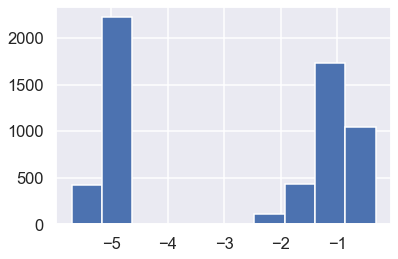

In [360]:
df_pplacer_cc11["E_adcl_log"] = np.log10(df_pplacer_cc11.B_adcl+0.000001)
plt.hist(df_pplacer_cc11.B_adcl_log)

In [247]:
adcl_CC11CM0 = adcl_cc11.loc[adcl_cc11.community=='CC11CM0']
edpl_CC11CM0 =edpl_cc11.loc[edpl_cc11.community=='CC11CM0']
mindistl_CC11CM0 =mindistl_cc11.loc[mindistl_cc11.community=='CC11CM0']
prichness_CC11CM0 =prichness_cc11.loc[prichness_cc11.community=='CC11CM0']

In [248]:
adcl_CC11CM0_score = pd.merge(adcl_CC11CM0,score_table2, left_on = 'sourceSeq', right_on = 'sv_id')
edpl_CC11CM0_score = pd.merge(edpl_CC11CM0,score_table2, left_on = 'sourceSeq', right_on = 'sv_id')
mindistl_CC11CM0_score = pd.merge(mindistl_CC11CM0,score_table2, left_on = 'sourceSeq', right_on = 'sv_id')
prichness_CC11CM0_score = pd.merge(prichness_CC11CM0,score_table2, left_on = 'sourceSeq', right_on = 'sv_id')

In [249]:
adcl_CC11CM0_RDP_10398 = adcl_CC11CM0_score[['seqID', 'CC11CM0', 'RDP_10398']]
edpl_CC11CM0_RDP_10398 = edpl_CC11CM0_score[['seqID', 'CC11CM0', 'RDP_10398']]
mindistl_CC11CM0_RDP_10398 = mindistl_CC11CM0_score[['seqID', 'CC11CM0', 'RDP_10398']]
prichess_CC11CM0_RDP_10398 = prichness_CC11CM0_score[['seqID', 'CC11CM0', 'RDP_10398']]

In [250]:
adcl_CC11CM0_RDP_10398.describe()

,CC11CM0,RDP_10398
count,55.000000,55.000000
mean,4.618182,0.031360
std,8.910025,0.087752
min,0.000000,0.000001
25%,2.000000,0.000006
50%,2.000000,0.000008
75%,2.000000,0.000010
max,38.000000,0.452194


In [345]:
score_table2.head()

,sv_id,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
0,AB542765.1.1491,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGXW01000013.688.2204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HQ457030.1.1394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,JHEF01000050.37729.39243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GU326240.1.1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [379]:
df_pplacer_cc11.head()


,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl,A_edpl,B_edpl,C_edpl,D_edpl,E_edpl,...,community,sourceSeq,seqID,organism,ncbi_tax_id,multiplicity,B_adcl_log,C_adcl_log,D_adcl_log,E_adcl_log
0,0.000007,0.137668,0.021522,0.155496,0.204297,0.000000,0.031116,0.065103,0.015844,0.000000,...,CC11CM81,NR_041278.1,CC11CM81SCReeb34a221dca4dc5b0ca403cc9ac9bd3,Bacteroides coprocola DSM 17136,470145,136,-0.861164,-0.861164,-0.861164,-0.861164
1,0.000009,0.000010,0.218740,0.198498,0.294593,0.000000,0.000000,0.087836,0.044412,0.034954,...,CC11CM99,NR_133689.1,CC11CM99SCRce2d1fa684f340c68b6f3239c2de2521,Aestuariispira insulae,1461337,822,-4.958607,-4.958607,-4.958607,-4.958607
2,0.194120,0.097577,0.179467,0.287096,0.215959,0.054320,0.007233,0.062781,0.012353,0.054546,...,CC11CM7,NR_113408.1,CC11CM7SCR9e29ef94a3604006b11d4566a917e44b,[Clostridium] propionicum,28446,14,-1.010648,-1.010648,-1.010648,-1.010648
3,0.053160,0.149998,0.097881,0.112167,0.065455,0.175707,0.058362,0.011408,0.005827,0.000000,...,CC11CM11,NR_113328.1,CC11CM11SCR22fac7d980eb496c9258d2c043fb6ea0,Parasutterella secunda,626947,1873,-0.823912,-0.823912,-0.823912,-0.823912
4,0.000007,0.000006,0.126795,0.186934,0.267457,0.000000,0.000000,0.080773,0.002828,0.070298,...,CC11CM34,NR_042007.1,CC11CM34SCR39303fc7db3e46a0be0bc45364d289ff,Roseburia inulinivorans DSM 16841,622312,204,-5.154902,-5.154902,-5.154902,-5.154902


(array([2592.,    0.,    0.,    0.,    0.,    0.,   10.,  224., 1133.,
        2015.]), array([-16.        , -14.44417055, -12.88834111, -11.33251166,
         -9.77668221,  -8.22085276,  -6.66502332,  -5.10919387,
         -3.55336442,  -1.99753497,  -0.44170553]), <a list of 10 Patch objects>)

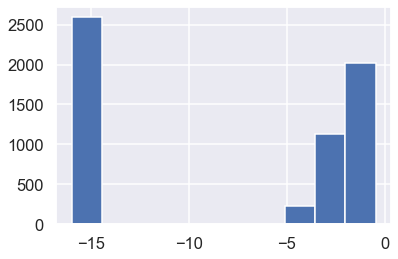

In [391]:
plt.hist(np.log10(df_pplacer_cc11.A_edpl+0.0000000000000001))  # minimal non-zero value divided by 100.

In [393]:
df_pplacer_cc11.describe()

,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl,A_edpl,B_edpl,C_edpl,D_edpl,E_edpl,...,B_prichness,C_prichness,D_prichness,E_prichness,ncbi_tax_id,multiplicity,B_adcl_log,C_adcl_log,D_adcl_log,E_adcl_log
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,...,5974.000000,5974.000000,5974.000000,5974.000000,5.974000e+03,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,0.030870,0.067427,0.110561,0.140690,0.166655,0.019395,0.021035,0.031887,0.033674,0.022970,...,5.068631,5.379645,5.478072,6.038165,4.893355e+05,802.088718,-2.862212,-2.862212,-2.862212,-2.862212
std,0.076025,0.092905,0.106539,0.087717,0.087512,0.044893,0.038966,0.062647,0.062739,0.026978,...,5.629558,4.954691,5.276621,4.627806,4.425526e+05,1251.463832,2.038894,2.038894,2.038894,2.038894
min,0.000001,0.000001,0.000001,0.000005,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,5.460000e+02,1.000000,-5.698970,-5.698970,-5.698970,-5.698970
25%,0.000006,0.000007,0.019634,0.068713,0.083255,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,8.218825e+04,56.000000,-5.096910,-5.096910,-5.096910,-5.096910
50%,0.000008,0.024131,0.088957,0.130732,0.176666,0.000617,0.003024,0.007771,0.016452,0.013817,...,3.000000,3.000000,3.000000,5.000000,3.870900e+05,322.000000,-1.617407,-1.617407,-1.617407,-1.617407
75%,0.019636,0.099829,0.177335,0.198498,0.248669,0.019254,0.028197,0.036618,0.035785,0.042923,...,7.000000,7.000000,7.000000,11.000000,7.453680e+05,1021.750000,-1.000739,-1.000739,-1.000739,-1.000739
max,0.452194,0.483433,0.435116,0.359080,0.297615,0.361655,0.284314,0.840492,0.542972,0.126934,...,20.000000,20.000000,20.000000,17.000000,1.577349e+06,18403.000000,-0.315663,-0.315663,-0.315663,-0.315663


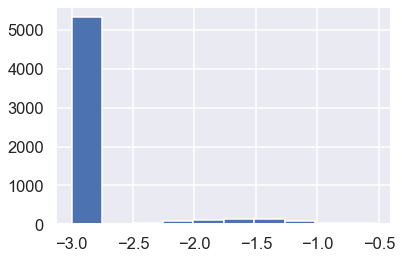

In [410]:
plt.hist(np.log10(df_pplacer_cc11.A_mindistl+0.001));


In [412]:
df_pplacer_cc11.C_mindistl.describe()

count    5.974000e+03
mean     1.839854e-02
std      4.808566e-02
min      5.196400e-07
25%      5.887012e-06
50%      7.985791e-06
75%      1.254981e-02
max      3.345772e-01
Name: C_mindistl, dtype: float64

In [251]:
edpl_CC11CM0_RDP_10398=edpl_CC11CM0_RDP_10398.rename(columns={"RDP_10398":"RDP_10398_edpl", "CC11CM0":"CC11CM0_score"})
adcl_CC11CM0_RDP_10398=adcl_CC11CM0_RDP_10398.rename(columns={"RDP_10398":"RDP_10398_adcl", "CC11CM0":"CC11CM0_score"})
mindistl_CC11CM0_RDP_10398=mindistl_CC11CM0_RDP_10398.rename(columns={"RDP_10398":"RDP_10398_mindistl", "CC11CM0":"CC11CM0_score"})
prichness_CC11CM0_RDP_10398=prichess_CC11CM0_RDP_10398.rename(columns={"RDP_10398":"RDP_10398_prichness", "CC11CM0":"CC11CM0_score"})

In [252]:
mindistl_CC11CM0_RDP_10398.head()

,seqID,CC11CM0_score,RDP_10398_mindistl
0,CC11CM0SCR00cdec97c058446e83e0ef032e61806d,2.0,7.189148e-06
1,CC11CM0SCR35529da454f0497fa16e04841e8e1639,34.0,5.645650e-07
2,CC11CM0SCR1083e70ce28e4961b8298356c0d69000,2.0,6.238599e-06
3,CC11CM0SCR8898bf89e307445282cd2fb3acb183a0,2.0,5.146191e-06
4,CC11CM0SCRfc7f700b82e44da39405162a7e5b8b77,2.0,5.645650e-07


In [253]:
df_list_all = [adcl_CC11CM0_RDP_10398,edpl_CC11CM0_RDP_10398,mindistl_CC11CM0_RDP_10398,prichness_CC11CM0_RDP_10398 ]

In [254]:
df_stats_combined=reduce(lambda x, y: pd.merge(x, y, on = ['seqID', 'CC11CM0_score']), df_list_all)

df_stats_combined.head()


,seqID,CC11CM0_score,RDP_10398_adcl,RDP_10398_edpl,RDP_10398_mindistl,RDP_10398_prichness
0,CC11CM0SCR00cdec97c058446e83e0ef032e61806d,2.0,0.000007,0.000000,7.189148e-06,1.0
1,CC11CM0SCR35529da454f0497fa16e04841e8e1639,34.0,0.000008,0.086949,5.645650e-07,20.0
2,CC11CM0SCR1083e70ce28e4961b8298356c0d69000,2.0,0.000006,0.000000,6.238599e-06,1.0
3,CC11CM0SCR8898bf89e307445282cd2fb3acb183a0,2.0,0.000005,0.010897,5.146191e-06,3.0
4,CC11CM0SCRfc7f700b82e44da39405162a7e5b8b77,2.0,0.000001,0.090313,5.645650e-07,20.0


In [341]:
df_stats_combined.describe()

,CC11CM0_score,RDP_10398_adcl,RDP_10398_edpl,RDP_10398_mindistl,RDP_10398_prichness,RDP_10398_adcl_log,RDP_10398_edpl_log,CC11CM0_score_log,RDP_10398_mindistl_log,RDP_10398_prichness_log
count,55.000000,55.000000,55.000000,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,4.618182,0.031360,0.023984,5.055836e-03,4.054545,-4.242693,-8.412563,-0.762236,-4.706604,0.378129
std,8.910025,0.087752,0.061902,1.576482e-02,5.115040,1.796455,7.025964,4.320515,1.397079,0.417883
min,0.000000,0.000001,0.000000,5.645650e-07,1.000000,-6.000000,-16.000000,-16.000000,-6.248286,0.000000
25%,2.000000,0.000006,0.000000,5.439325e-06,1.000000,-5.221849,-16.000000,0.301030,-5.264457,0.000000
50%,2.000000,0.000008,0.000497,6.751801e-06,3.000000,-5.096910,-3.303388,0.301030,-5.170580,0.477121
75%,2.000000,0.000010,0.011681,8.353680e-06,3.500000,-5.022879,-1.932516,0.301030,-5.078128,0.539591
max,38.000000,0.452194,0.361655,8.232138e-02,20.000000,-0.344675,-0.441706,1.579784,-1.084487,1.301030


In [355]:
# plt.hist(df_stats_combined.RDP_1017_adcl)

AttributeError: 'DataFrame' object has no attribute 'RDP_1017_adcl'

(array([ 3., 39.,  0.,  0.,  0.,  0.,  0.,  2.,  8.,  3.]),
 array([-6.        , -5.43446752, -4.86893504, -4.30340256, -3.73787008,
        -3.1723376 , -2.60680512, -2.04127264, -1.47574016, -0.91020768,
        -0.3446752 ]),
 <a list of 10 Patch objects>)

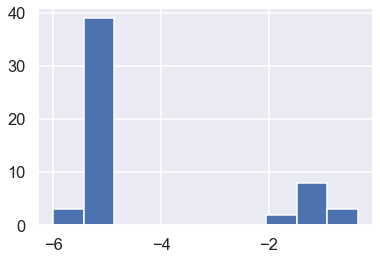

In [349]:
plt.hist(df_stats_combined.RDP_10398_adcl_log)

In [354]:
# displayFancy("plt.hist(df_stats_combined.RDP_10398_adcl)","plt.hist(df_stats_combined.RDP_10398_adcl_log)")

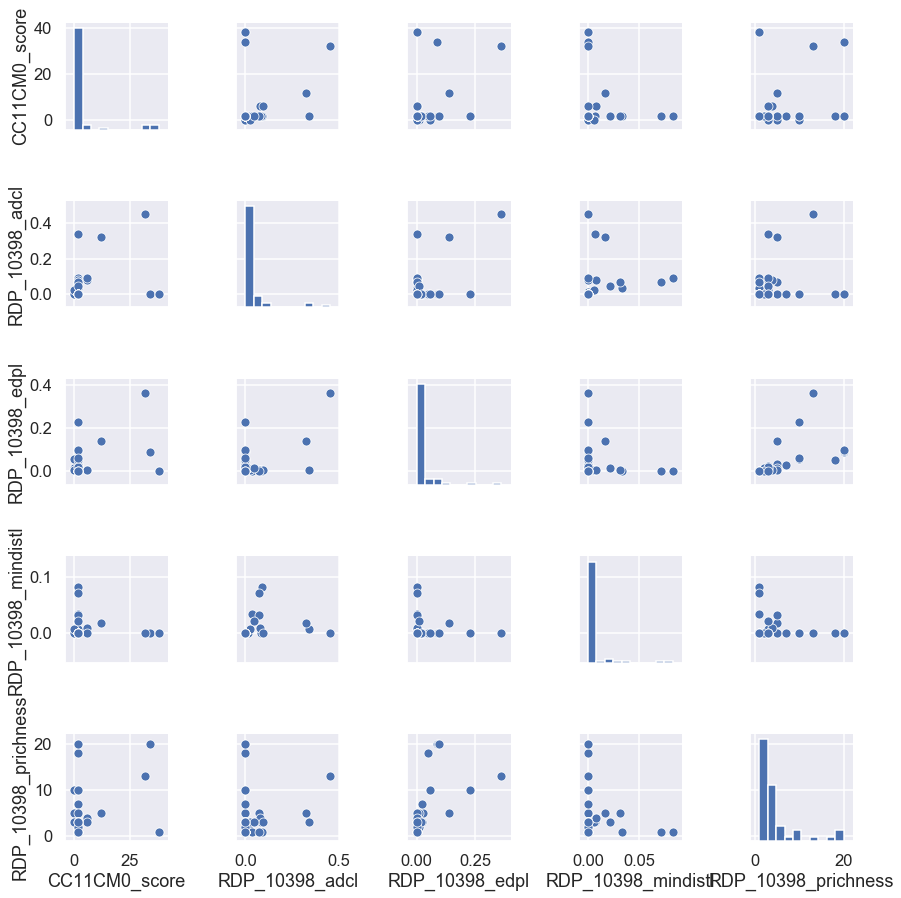

In [255]:
sns.pairplot(df_stats_combined)

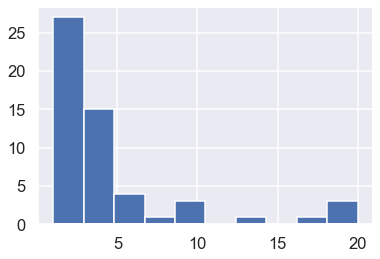

In [397]:
plt.hist(df_stats_combined.RDP_10398_prichness_nonlog);

In [395]:
df_stats_combined['RDP_10398_adcl_log'] = np.log10(df_stats_combined.RDP_10398_adcl+0.0000000000000001)
df_stats_combined['RDP_10398_edpl_log'] = np.log10(df_stats_combined.RDP_10398_edpl+0.0000000000000001)
df_stats_combined['CC11CM0_score_nonlog'] = df_stats_combined.CC11CM0_score
df_stats_combined['RDP_10398_mindistl_log'] = np.log10(df_stats_combined.RDP_10398_mindistl+0.0000000000000001)
df_stats_combined['RDP_10398_prichness_nonlog'] = df_stats_combined.RDP_10398_prichness
df_stats_combined.head()

,seqID,CC11CM0_score,RDP_10398_adcl,RDP_10398_edpl,RDP_10398_mindistl,RDP_10398_prichness,RDP_10398_adcl_log,RDP_10398_edpl_log,CC11CM0_score_log,RDP_10398_mindistl_log,RDP_10398_prichness_log,CC11CM0_score_log2,CC11CM0_score_nonlog,RDP_10398_prichness_nonlog
0,CC11CM0SCR00cdec97c058446e83e0ef032e61806d,2.0,0.000007,0.000000,7.189148e-06,1.0,-5.154902,-16.000000,0.301030,-5.143323,0.000000,1.000000,2.0,1.0
1,CC11CM0SCR35529da454f0497fa16e04841e8e1639,34.0,0.000008,0.086949,5.645650e-07,20.0,-5.096910,-1.060736,1.531479,-6.248286,1.301030,5.087463,34.0,20.0
2,CC11CM0SCR1083e70ce28e4961b8298356c0d69000,2.0,0.000006,0.000000,6.238599e-06,1.0,-5.221849,-16.000000,0.301030,-5.204913,0.000000,1.000000,2.0,1.0
3,CC11CM0SCR8898bf89e307445282cd2fb3acb183a0,2.0,0.000005,0.010897,5.146191e-06,3.0,-5.301030,-1.962705,0.301030,-5.288514,0.477121,1.000000,2.0,3.0
4,CC11CM0SCRfc7f700b82e44da39405162a7e5b8b77,2.0,0.000001,0.090313,5.645650e-07,20.0,-6.000000,-1.044248,0.301030,-6.248286,1.301030,1.000000,2.0,20.0


In [366]:
df_stats_combined_log = df_stats_combined[["seqID","CC11CM0_score_nonlog","RDP_10398_adcl_log","RDP_10398_edpl_log","RDP_10398_mindistl_log","RDP_10398_prichness_nonlog"]]
df_stats_combined_log.head()

,seqID,CC11CM0_score_nonlog,RDP_10398_adcl_log,RDP_10398_edpl_log,RDP_10398_mindistl_log,RDP_10398_prichness_nonlog
0,CC11CM0SCR00cdec97c058446e83e0ef032e61806d,2.0,-5.154902,-16.000000,-5.143323,1.0
1,CC11CM0SCR35529da454f0497fa16e04841e8e1639,34.0,-5.096910,-1.060736,-6.248286,20.0
2,CC11CM0SCR1083e70ce28e4961b8298356c0d69000,2.0,-5.221849,-16.000000,-5.204913,1.0
3,CC11CM0SCR8898bf89e307445282cd2fb3acb183a0,2.0,-5.301030,-1.962705,-5.288514,3.0
4,CC11CM0SCRfc7f700b82e44da39405162a7e5b8b77,2.0,-6.000000,-1.044248,-6.248286,20.0


In [367]:
df_stats_combined_log = df_stats_combined_log.rename(columns={"seqID":"CC11CM0_RDP10398_seqID","CC11CM0_score_log":"score_log","RDP_10398_adcl_log":"adcl_log","RDP_10398_edpl_log":"edpl_log","RDP_10398_mindistl_log":"mindistl_log","RDP_10398_prichness_log":"prichness_log"})

In [368]:
df_stats_combined_log.head()

,CC11CM0_RDP10398_seqID,CC11CM0_score_nonlog,adcl_log,edpl_log,mindistl_log,RDP_10398_prichness_nonlog
0,CC11CM0SCR00cdec97c058446e83e0ef032e61806d,2.0,-5.154902,-16.000000,-5.143323,1.0
1,CC11CM0SCR35529da454f0497fa16e04841e8e1639,34.0,-5.096910,-1.060736,-6.248286,20.0
2,CC11CM0SCR1083e70ce28e4961b8298356c0d69000,2.0,-5.221849,-16.000000,-5.204913,1.0
3,CC11CM0SCR8898bf89e307445282cd2fb3acb183a0,2.0,-5.301030,-1.962705,-5.288514,3.0
4,CC11CM0SCRfc7f700b82e44da39405162a7e5b8b77,2.0,-6.000000,-1.044248,-6.248286,20.0


In [369]:
df_stats_combined_log.head()

,CC11CM0_RDP10398_seqID,CC11CM0_score_nonlog,adcl_log,edpl_log,mindistl_log,RDP_10398_prichness_nonlog
0,CC11CM0SCR00cdec97c058446e83e0ef032e61806d,2.0,-5.154902,-16.000000,-5.143323,1.0
1,CC11CM0SCR35529da454f0497fa16e04841e8e1639,34.0,-5.096910,-1.060736,-6.248286,20.0
2,CC11CM0SCR1083e70ce28e4961b8298356c0d69000,2.0,-5.221849,-16.000000,-5.204913,1.0
3,CC11CM0SCR8898bf89e307445282cd2fb3acb183a0,2.0,-5.301030,-1.962705,-5.288514,3.0
4,CC11CM0SCRfc7f700b82e44da39405162a7e5b8b77,2.0,-6.000000,-1.044248,-6.248286,20.0


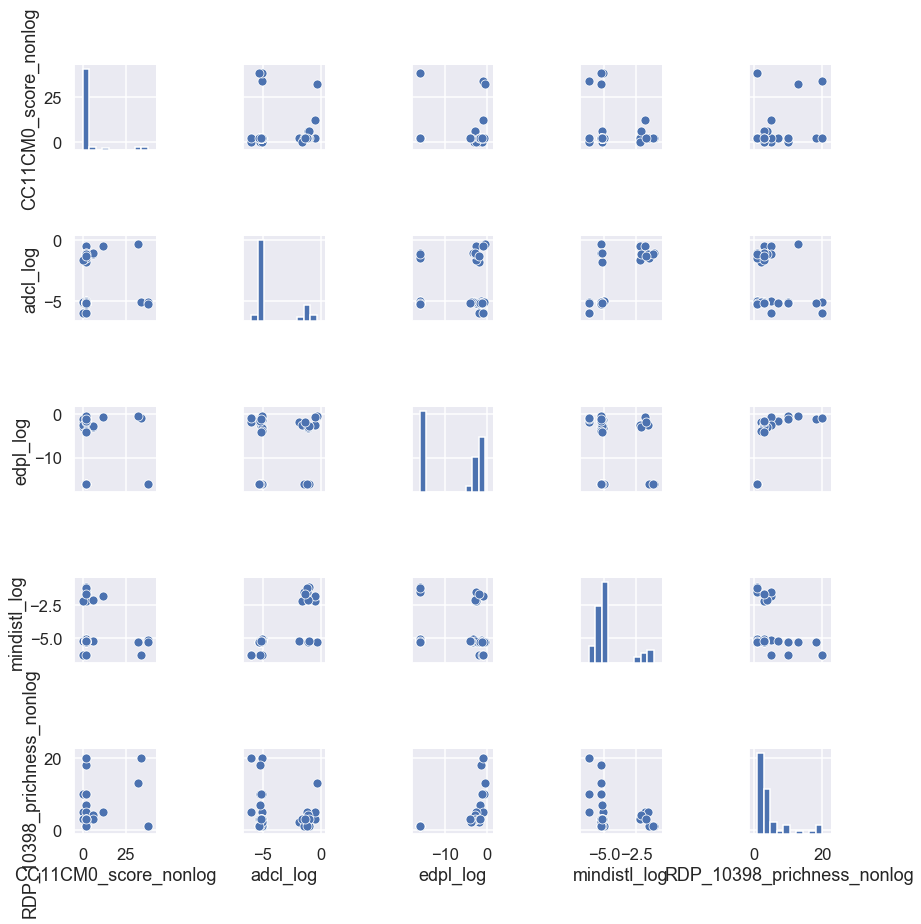

In [370]:
sns.pairplot(df_stats_combined_log)

In [371]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

In [372]:
# df_stats_combined_log.corr(method=histogram_intersection)

In [373]:
df_stats_combined_log.corr()

,CC11CM0_score_nonlog,adcl_log,edpl_log,mindistl_log,RDP_10398_prichness_nonlog
CC11CM0_score_nonlog,1.000000,0.099088,-0.000586,-0.092472,0.225166
adcl_log,0.099088,1.000000,0.220745,0.783043,-0.081844
edpl_log,-0.000586,0.220745,1.000000,-0.027482,0.603548
mindistl_log,-0.092472,0.783043,-0.027482,1.000000,-0.265821
RDP_10398_prichness_nonlog,0.225166,-0.081844,0.603548,-0.265821,1.000000


(array([25.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 11., 17.]),
 array([-16.        , -14.44417055, -12.88834111, -11.33251166,
         -9.77668221,  -8.22085276,  -6.66502332,  -5.10919387,
         -3.55336442,  -1.99753497,  -0.44170553]),
 <a list of 10 Patch objects>)

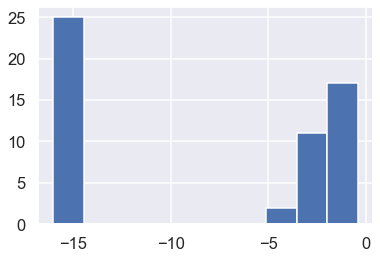

In [378]:
plt.hist(df_stats_combined_log.edpl_log)

In [374]:
adcl_cc11.columns

Index(['level_0', 'index', 'RDP_10398', 'RDP_5224', 'RDP_1017', 'RDP_92',
       'RDP_12', 'community', 'sourceSeq', 'seqID', 'organism', 'ncbi_tax_id',
       'multiplicity'],
      dtype='object')

In [375]:
df_pcorrect.index

Index(['CC11CM0', 'CC11CM1', 'CC11CM10', 'CC11CM11', 'CC11CM12', 'CC11CM13',
       'CC11CM14', 'CC11CM15', 'CC11CM16', 'CC11CM17', 'CC11CM18', 'CC11CM19',
       'CC11CM2', 'CC11CM20', 'CC11CM21', 'CC11CM22', 'CC11CM23', 'CC11CM24',
       'CC11CM25', 'CC11CM26', 'CC11CM27', 'CC11CM28', 'CC11CM29', 'CC11CM3',
       'CC11CM30', 'CC11CM31', 'CC11CM32', 'CC11CM33', 'CC11CM34', 'CC11CM35',
       'CC11CM36', 'CC11CM37', 'CC11CM38', 'CC11CM39', 'CC11CM4', 'CC11CM40',
       'CC11CM41', 'CC11CM42', 'CC11CM43', 'CC11CM44', 'CC11CM45', 'CC11CM46',
       'CC11CM47', 'CC11CM48', 'CC11CM49', 'CC11CM5', 'CC11CM50', 'CC11CM51',
       'CC11CM52', 'CC11CM53', 'CC11CM54', 'CC11CM55', 'CC11CM56', 'CC11CM57',
       'CC11CM58', 'CC11CM59', 'CC11CM6', 'CC11CM60', 'CC11CM61', 'CC11CM62',
       'CC11CM63', 'CC11CM64', 'CC11CM65', 'CC11CM66', 'CC11CM67', 'CC11CM68',
       'CC11CM69', 'CC11CM7', 'CC11CM70', 'CC11CM71', 'CC11CM72', 'CC11CM73',
       'CC11CM74', 'CC11CM75', 'CC11CM76', 'CC11CM77', 'CC11

In [376]:
sensitivity_10 = df_pcorrect.loc[['CC11CM0', 'CC11CM1', 'CC11CM2', 'CC11CM3', 'CC11CM4', 'CC11CM5',
       'CC11CM6', 'CC11CM7', 'CC11CM8', 'CC11CM9','CC11CM10', 'CC11CM11', 'CC11CM1', 'CC11CM13', 'CC11CM14', 'CC11CM15',
       'CC11CM16', 'CC11CM17', 'CC11CM18', 'CC11CM19']]

In [377]:
sensitivity_10

,rdp_10398,rdp_5224,rdp_1017,rdp_92,rdp_12
CC11CM0,5.765636,5.765636,3.159084,2.504251,0.0
CC11CM1,0.363896,0.378621,0.000000,0.000000,0.0
CC11CM2,0.743100,0.743100,0.743100,0.000000,0.0
CC11CM3,0.000000,0.000000,0.000000,0.000000,0.0
CC11CM4,0.546669,0.435311,0.430741,0.000000,0.0
CC11CM5,0.883439,3.843878,3.466427,3.466427,0.0
CC11CM6,1.707271,1.707271,1.005509,0.000000,0.0
CC11CM7,0.988916,1.269109,1.269109,1.269109,0.0
CC11CM8,4.696282,4.696282,3.632541,2.393920,0.0
CC11CM9,6.264562,3.415929,3.334887,0.000000,0.0


## Read score tables

In [81]:
rdp_10398_score = pd.read_csv("rdp_10398score.csv", index_col=0)
rdp_5224_score = pd.read_csv("rdp_5224score.csv", index_col=0)
rdp_1017_score = pd.read_csv("rdp_1017score.csv", index_col=0)
rdp_92_score = pd.read_csv("rdp_92score.csv", index_col=0)
rdp_12_score = pd.read_csv("rdp_12score.csv", index_col=0)

In [347]:
rdp_1017_score.describe()

,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,CC11CM9,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
count,55.000000,73.000000,40.000000,59.000000,51.000000,61.000000,54.000000,67.000000,65.000000,57.000000,...,48.000000,59.000000,53.000000,61.000000,53.000000,61.000000,50.000000,57.000000,62.000000,56.000000
mean,15.418182,12.876712,13.650000,9.525424,9.137255,13.737705,14.148148,10.626866,11.046154,13.087719,...,11.791667,9.864407,12.754717,14.655738,10.113208,9.540984,11.400000,11.719298,10.806452,11.964286
std,20.751342,17.959789,17.517098,15.060059,13.237854,20.160937,19.957887,17.691665,18.262351,20.777977,...,16.421261,18.155894,17.263685,18.216188,14.620402,14.946096,18.679903,17.281033,14.478745,18.340184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,4.000000,2.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2.000000,4.000000,6.000000
75%,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,6.000000,14.000000,14.000000,14.000000,12.000000,14.000000,14.000000,14.000000,14.000000
max,62.000000,62.000000,62.000000,62.000000,62.000000,94.000000,62.000000,94.000000,94.000000,94.000000,...,62.000000,94.000000,62.000000,62.000000,62.000000,62.000000,94.000000,62.000000,62.000000,94.000000


In [83]:
rdp_10398_score.head(1)

,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,CC11CM9,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
sv_id,,,,,,,,,,,,,,,,,,,,,
AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,6.0,6.0,NaN,NaN,NaN,6.0,NaN,NaN


In [84]:
rdp_10398_score.shape

(1830, 100)

In [85]:
combined =pd.DataFrame(columns=["unique_index", "rdp10398"])

In [86]:
combined=combined.append({'unique_index': 'abd', 'rdp10398': 12}, ignore_index=True)
combined.columns

Index(['unique_index', 'rdp10398'], dtype='object')

In [87]:
combined

,unique_index,rdp10398
0,abd,12


In [88]:
str("abc") + str("xyz")
rdp_10398_score.loc["AGEL01000014.278829.280347","CC11CM0"]

nan

In [89]:
indices=rdp_10398_score.index
communities =rdp_10398_score.columns

In [90]:
for mock_id in indices:
    for community in communities:
        combined=combined.append({'unique_index': str(community)+str(mock_id), 'rdp10398': rdp_10398_score.loc[mock_id,community]}, ignore_index=True)
        

In [91]:
combined.columns

Index(['unique_index', 'rdp10398'], dtype='object')

In [92]:
# This function converts table with the index of community name and the sv_id name
def convert_score_table(score_table, prefix): 
    new_table=pd.DataFrame(columns=["unique_index", prefix])
    indices=score_table.index
    communities =score_table.columns
    for mock_id in indices:
        for community in communities:
           new_table=new_table.append({'unique_index': str(community)+str(mock_id), prefix: score_table.loc[mock_id,community]}, ignore_index=True)
    new_table.set_index('unique_index')
    return new_table
    
    

In [430]:
new_table=pd.DataFrame(columns=["","unique_index", "rdp_10398"])

In [432]:
new_table

,unique_index,rdp_10398


In [434]:
rdp_10398_score.head()

,CC11CM0,CC11CM1,CC11CM2,CC11CM3,CC11CM4,CC11CM5,CC11CM6,CC11CM7,CC11CM8,CC11CM9,...,CC11CM90,CC11CM91,CC11CM92,CC11CM93,CC11CM94,CC11CM95,CC11CM96,CC11CM97,CC11CM98,CC11CM99
sv_id,,,,,,,,,,,,,,,,,,,,,
AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,6.0,6.0,NaN,NaN,NaN,6.0,NaN,NaN
AB640694.1.1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NR_041895.1,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQ486127.1.1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NR_024683.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [469]:

def colName(prefix, n):
    A=[]
    for i in range(n):
        A.append(str(prefix)+str(i))
    return A


In [468]:
rdp_10398_score.columns= colName("A",100)
rdp_5224_score.columns= colName("B",100)
rdp_1017_score.columns= colName("C",100)
rdp_92_score.columns= colName("D",100)
rdp_12_score.columns= colName("E",100)

In [470]:
rdp_12_score.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E90,E91,E92,E93,E94,E95,E96,E97,E98,E99
sv_id,,,,,,,,,,,,,,,,,,,,,
AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,...,NaN,NaN,62.0,62.0,NaN,NaN,NaN,62.0,NaN,NaN
AB640694.1.1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NR_041895.1,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQ486127.1.1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NR_024683.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [472]:
score_list = [rdp_10398_score,rdp_5224_score,rdp_1017_score, rdp_92_score,rdp_12_score ]
all_scores=reduce(lambda x, y: pd.merge(x, y, on = ['sv_id', ]), score_list)

all_scores.to_csv("all_score.csv")

In [473]:
all_scores.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,E90,E91,E92,E93,E94,E95,E96,E97,E98,E99
sv_id,,,,,,,,,,,,,,,,,,,,,
AGEL01000014.278829.280347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,62.0,62.0,NaN,NaN,NaN,62.0,NaN,NaN
AB640694.1.1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NR_041895.1,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQ486127.1.1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NR_024683.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [476]:
df_pplacer_cc11.columns

Index(['A_adcl', 'B_adcl', 'C_adcl', 'D_adcl', 'E_adcl', 'A_edpl', 'B_edpl',
       'C_edpl', 'D_edpl', 'E_edpl', 'A_mindistl', 'B_mindistl', 'C_mindistl',
       'D_mindistl', 'E_mindistl', 'A_prichness', 'B_prichness', 'C_prichness',
       'D_prichness', 'E_prichness', 'community', 'sourceSeq', 'seqID',
       'organism', 'ncbi_tax_id', 'multiplicity', 'B_adcl_log', 'C_adcl_log',
       'D_adcl_log', 'E_adcl_log'],
      dtype='object')

In [487]:
all_data = pd.merge(df_pplacer_cc11, all_scores, left_on='sourceSeq', right_on='sv_id')
all_data.to_csv("all_data.csv")

In [474]:
# rdp_10398_converted = convert_score_table(rdp_10398_score, "rdp_10398")
# rdp_5224_converted = convert_score_table(rdp_5224_score, "rdp_5224")
# rdp_1017_converted = convert_score_table(rdp_1017_score, "rdp_1017")
# rdp_92_converted = convert_score_table(rdp_92_score, "rdp_92")
# rdp_12_converted = convert_score_table(rdp_12_score, "rdp_12")


In [94]:
rdp_10398_converted.to_csv("rdp_10398_converted.csv")
rdp_5224_converted.to_csv("rdp_5224_converted.csv")
rdp_1017_converted.to_csv("rdp_1017_converted.csv")
rdp_92_converted.to_csv("rdp_92_converted.csv")
rdp_12_converted.to_csv("rdp_12_converted.csv")

In [95]:
data_frames=[rdp_10398_converted,rdp_5224_converted,rdp_1017_converted,rdp_92_converted,rdp_12_converted]

In [96]:
rdp_12_converted.columns

Index(['unique_index', 'rdp_12'], dtype='object')

In [97]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['unique_index'],
                                            how='outer'), data_frames)
df_merged.rename(columns={'rdp_10398':'RDP_10398_score','rdp_5224':'RDP_5224_score','rdp_1017':'RDP_1017_score','rdp_92':'RDP_92_score','rdp_12':'RDP_12_score' }, inplace=True)
df_merged.columns

Index(['unique_index', 'RDP_10398_score', 'RDP_5224_score', 'RDP_1017_score',
       'RDP_92_score', 'RDP_12_score'],
      dtype='object')

In [98]:
df_merged.to_csv("score_merged.csv")

In [99]:
adcl_cc11.columns


Index(['index', 'RDP_10398', 'RDP_5224', 'RDP_1017', 'RDP_92', 'RDP_12',
       'community', 'sourceSeq', 'seqID', 'organism', 'ncbi_tax_id',
       'multiplicity'],
      dtype='object')

In [100]:
adcl_pplacer = adcl_cc11.rename(columns={'RDP_10398':'RDP_10398_adcl','RDP_5224':'RDP_5224_adcl','RDP_1017':'RDP_1017_adcl','RDP_92':'RDP_92_adcl','RDP_12':'RDP_12_adcl'})
edpl_pplacer = edpl_cc11.rename(columns={'RDP_10398':'RDP_10398_edpl','RDP_5224':'RDP_5224_edpl','RDP_1017':'RDP_1017_edpl','RDP_92':'RDP_92_edpl','RDP_12':'RDP_12_edpl'})
mindistl_pplacer = mindistl_cc11.rename(columns={'RDP_10398':'RDP_10398_mindistl','RDP_5224':'RDP_5224_mindistl','RDP_1017':'RDP_1017_mindistl','RDP_92':'RDP_92_mindistl','RDP_12':'RDP_12_mindistl'})
# prichness_pplacer=prichness.rename(columns={'newIndex':'seqID','RDP_10398':'RDP_10398_prichness','RDP_5224':'RDP_5224_prichness','RDP_1017':'RDP_1017_prichness','RDP_92':'RDP_92_prichness','RDP_12':'RDP_12_prichness'})
prichness_pplacer = prichness_cc11.rename(columns={'RDP_10398':'RDP_10398_prichness','RDP_5224':'RDP_5224_prichness','RDP_1017':'RDP_1017_prichness','RDP_92':'RDP_92_prichness','RDP_12':'RDP_12_prichness'})


In [101]:
pplacer_stats=[adcl_pplacer,edpl_pplacer,mindistl_pplacer,prichness_pplacer]
pplacer_stats_merged = reduce(lambda  left,right: pd.merge(left,right,on=['seqID'],
                                            how='outer'), pplacer_stats)

In [102]:

pplacer_stats_merged.rename(columns={'seqID':'unique_index'}, inplace=True)
pplacer_stats_merged.to_csv("pplacer_stats_merged.csv")

In [103]:
# merge pplacer stats with scores
merged_dataframe_list = [pplacer_stats_merged,df_merged]
pplacer_stats_score_merged = reduce(lambda  left,right: pd.merge(left,right,on=['unique_index'],
                                            how='outer'), merged_dataframe_list)


In [104]:
pplacer_stats_score_merged.drop_duplicates()
pplacer_stats_score_merged.to_csv("pplacer_stats_score_merged.csv")

PermissionError: [Errno 13] Permission denied: 'pplacer_stats_score_merged.csv'

In [ ]:
# score_table_list= list()
# for f in {rdp_10398_score,rdp_5224_score,rdp_1017_score,rdp_92_score,rdp_12_score}:
#     score_table_list.append(f)
# # prefix_list = {"rdp_10398","rdp_5224","rdp_1017","rdp_92","rdp_12"}

In [ ]:
# df_combined_list={}
# for i in range(len(score_table_list)):
#    df_combined_list[i]=convert_score_table(score_table_list[i], prefix_list[i])

In [ ]:
# for i in range(len(score_table_list)):
#     print (i)

In [ ]:
# rdp_10398_score = pd.read_csv("rdp_10398score.csv", index_col=0)
# rdp_5224_score = pd.read_csv("rdp_5224score.csv", index_col=0)
# rdp_1017_score = pd.read_csv("rdp_1017score.csv", index_col=0)
# rdp_92_score = pd.read_csv("rdp_92score.csv", index_col=0)
# rdp_12_score = pd.read_csv("rdp_12score.csv", index_col=0)

In [489]:
all_data.head()

,A_adcl,B_adcl,C_adcl,D_adcl,E_adcl,A_edpl,B_edpl,C_edpl,D_edpl,E_edpl,...,E90,E91,E92,E93,E94,E95,E96,E97,E98,E99
0,0.000007,0.137668,0.021522,0.155496,0.204297,0.0,0.031116,0.065103,0.015844,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000007,0.137668,0.021522,0.155496,0.204297,0.0,0.031116,0.065103,0.015844,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000007,0.137668,0.021522,0.155496,0.204297,0.0,0.031116,0.065103,0.015844,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000007,0.137668,0.021522,0.155496,0.204297,0.0,0.031116,0.065103,0.015844,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000007,0.137668,0.021522,0.155496,0.204297,0.0,0.031116,0.065103,0.015844,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [482]:
all_data.A_adcl[all_data.A_adcl >0].min()

1e-06

In [495]:
all_data['A_adcl_log'] = np.log10(all_data.A_adcl+(all_data.A_adcl[all_data.A_adcl >0].min())/100)
all_data['B_adcl_log'] = np.log10(all_data.B_adcl+(all_data.B_adcl[all_data.B_adcl >0].min())/100)
all_data['C_adcl_log'] = np.log10(all_data.C_adcl+(all_data.C_adcl[all_data.C_adcl >0].min())/100)
all_data['D_adcl_log'] = np.log10(all_data.D_adcl+(all_data.D_adcl[all_data.D_adcl >0].min())/100)
all_data['E_adcl_log'] = np.log10(all_data.E_adcl+(all_data.E_adcl[all_data.E_adcl >0].min())/100)

In [497]:
all_data.to_csv("all_data.csv")

In [492]:
all_data.A_adcl[all_data.A_adcl >0]

0       0.000007
1       0.000007
2       0.000007
3       0.000007
4       0.000007
5       0.000009
6       0.000009
7       0.000009
8       0.000009
9       0.000009
10      0.000009
11      0.000009
12      0.000009
13      0.000009
14      0.000009
15      0.000009
16      0.000009
17      0.000009
18      0.000009
19      0.000009
20      0.000009
21      0.000009
22      0.000009
23      0.000009
24      0.000009
25      0.000009
26      0.000009
27      0.000009
28      0.000009
29      0.000009
          ...   
5944    0.069879
5945    0.062432
5946    0.000006
5947    0.046761
5948    0.000008
5949    0.000008
5950    0.000006
5951    0.000001
5952    0.031776
5953    0.000009
5954    0.000008
5955    0.006353
5956    0.000001
5957    0.000006
5958    0.000006
5959    0.024420
5960    0.000005
5961    0.000010
5962    0.000001
5963    0.000008
5964    0.000008
5965    0.000009
5966    0.000007
5967    0.000008
5968    0.057797
5969    0.000006
5970    0.013242
5971    0.0291